 This notebook uses a vanilla (basic) Bayesian optimization algorithm to tackle an urban travel demand (i.e.,  origin-destination, OD) calibration problem. The traffic simulations are based on the SUMO simulator. It considers a toy network, called quickstart detailed here:
 https://sumo.dlr.de/docs/Tutorials/quick_start.html

# Install sumo

In [79]:

#reimporting help to ensure the latest version is used
import importlib
import helpers_od_calibration
importlib.reload(helpers_od_calibration)

<module 'helpers_od_calibration' from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/helpers_od_calibration.py'>

Mount GDrive

If you are working w/ colab rather than a jupyterlab notebook this drive mounting and sumo installation will need to be done every time you restart the runtime.


Install SUMO

In [80]:

import os
from pathlib import Path 
import sys

os.environ['SUMO_HOME'] = '/Library/Frameworks/EclipseSUMO.framework/Versions/1.24.0/EclipseSUMO/share/sumo'
os.environ['LIBSUMO_AS_TRACI'] = '1' #Optional: for a huge performance boost (~8x) with Libsumo (No GUI)
SUMO_HOME = Path(os.environ['SUMO_HOME'])

if "SUMO_HOME" in os.environ:
    tools = os.path.join(os.environ["SUMO_HOME"], "tools")
    sys.path.append(tools)
else:
    sys.exit("Please declare the environment variable 'SUMO_HOME'")
#import traci


#print(SUMO_HOME)
#print(SUMO_HOME.parents[1])
#print(SUMO_HOME.parents[2])

import json, shutil

# Add the SUMO *bin* directory to PATH so od2trips/duarouter/sumo are found
# Your SUMO_HOME is .../EclipseSUMO/share/sumo → bin is two levels up, then /bin
SUMO_ROOT = Path(os.environ["SUMO_HOME"]).parents[1]          # .../EclipseSUMO
SUMO_BIN  = str(SUMO_ROOT / "bin") # this convert path to /EclipseSUMO/bin
LIB_SUMO_PATH = Path(os.environ["SUMO_HOME"]).parents[2] / "lib" / "libsumo.dylib"

os.environ["PATH"] = SUMO_BIN + os.pathsep + os.environ.get("PATH", "")

import traci
import sumolib


base_path = '/Users/inesbenhamza/Desktop/Sumo_od_calibration'
# if base_path has a space in it, the sumo code will not work
if ' ' in base_path:
    raise ValueError("base_path should not contain any spaces.")

os.chdir(base_path)

# Macros / utils

In [34]:
# install missing packages
!pip install gpytorch
!pip install botorch
!pip install matplotlib
!pip install pandas
!pip install seaborn 

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/bin/pip: line 2: /Users/inesbenhamza/Desktop/Sumo_od_calibration 3/env/bin/python: No such file or directory
/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/bin/pip: line 2: exec: /Users/inesbenhamza/Desktop/Sumo_od_calibration 3/env/bin/python: cannot execute: No such file or directory
/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/bin/pip: line 2: /Users/inesbenhamza/Desktop/Sumo_od_calibration 3/env/bin/python: No such file or directory
/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/bin/pip: line 2: exec: /Users/inesbenhamza/Desktop/Sumo_od_calibration 3/env/bin/python: cannot execute: No such file or directory
/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/bin/pip: line 2: /Users/inesbenhamza/Desktop/Sumo_od_calibration 3/env/bin/python: No such file or directory
/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/bin/pip: line 2: exec: /Users/inesbenhamza/Desktop/Sumo_od_calibration 3/env/bin/python: cannot exe

# library import 

In [81]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pprint
import seaborn as sns
from pathlib import Path

import torch
from torch.quasirandom import SobolEngine

from botorch import fit_gpytorch_mll
from botorch.acquisition import qLogExpectedImprovement
from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize
from botorch.optim import optimize_acqf
from botorch.sampling.stochastic_samplers import StochasticSampler
from botorch.utils.transforms import unnormalize, normalize

from gpytorch.constraints import Interval
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models.transforms.outcome import Standardize



from helpers_od_calibration import (load_kwargs_config,
                    compute_nrmse_counts_all_edges,
                    parse_loop_data_xml_to_pandas,
                    create_taz_xml,
                    simulate_od,
                    od_xml_to_df,
                    )

%matplotlib inline

# Create GT (ground truth) scenario

In [36]:
config = load_kwargs_config(base_path, "bo_vanilla")
Path(config["simulation_run_path"]).mkdir(parents=True, exist_ok=True)
pprint.pprint(dict(config))

{'BATCH_SIZE': 1,
 'EDGE_OUT_STR': 'edge_data_quickstart.xml',
 'NITER': 10,
 'NUM_RESTARTS': 5,
 'RAW_SAMPLES': 32,
 'SAMPLE_SHAPE': 128,
 'SUMO_PATH': PosixPath('/Library/Frameworks/EclipseSUMO.framework/Versions/1.24.0/EclipseSUMO/share/sumo'),
 'TRIPS2ODS_OUT_STR': 'trips.xml',
 'additional_xml': PosixPath('/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml'),
 'file_gt_od': PosixPath('/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/od.xml'),
 'fixed_routes': PosixPath('/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/routes.csv'),
 'model_name': 'bo_vanilla',
 'n_init_search': 5,
 'net_xml': PosixPath('/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml'),
 'network_name': 'quickstart',
 'network_path': PosixPath('network/quickstart'),
 'od_duration_sec': 300,
 'sim_end_time': 57600,
 'sim_start_time': 54000,
 'sim_stat_freq_sec': 300,
 'simulation_run_path': 'output/quickstart_bo_vanilla',


In [82]:
# Get Ground Truth OD + fixed routes
print(f"Reading: {config['file_gt_od']}")
gt_od_df = od_xml_to_df(config["file_gt_od"]) #Ground Truth OD 

print(f"Reading: {config['fixed_routes']}")
routes_df = pd.read_csv(config["fixed_routes"], index_col=0) #Fixed routes

Reading: /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/od.xml
total GT demand:  2800.0
Reading: /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/routes.csv


Simulate the GT scenario to obtain the GT traffic statistics

In [83]:
#not installed in virtual env 
#import sys
#!{sys.executable} -m pip install lxml

### simulate the GT scenario to obtain the GT traffic statitics 

In [84]:
simulation_gt_run_path =f'{config["simulation_run_path"]}/ground_truth'
prefix_output_gt = f'{simulation_gt_run_path}/sim'
sim_edge_out_gt = f'{prefix_output_gt}_{config["EDGE_OUT_STR"]}'
new_od_xml = f'{simulation_gt_run_path}/od.xml'
print(simulation_gt_run_path)

Path(simulation_gt_run_path).mkdir(parents=True, exist_ok=True) #Creates directory for ground truth simulation outputs

output/quickstart_bo_vanilla/ground_truth


In [85]:

base_od = gt_od_df.copy()
gt_od_vals = gt_od_df['count'].astype(float).to_numpy()
curr_od = gt_od_vals.copy()
base_od['count'] = curr_od
base_od = base_od.rename(columns={'fromTaz':'from', 'toTaz':'to'})
create_taz_xml(new_od_xml, base_od, config["od_duration_sec"], base_path) 

print(base_od)


Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/ground_truth/od.xml
    from     to  count  data
0  taz91  taz93  500.0  None
1  taz91  taz94  500.0  None
2  taz92  taz93  900.0  None
3  taz92  taz94  900.0  None


### Run simulation to produce the traffic on eachlink given the ground trutch demand for each od pair, so here we simulate the GT scenario to obtain the GT traffic statitics 

In [40]:
simulate_od(new_od_xml,
            prefix_output_gt,
            base_path,
            config["net_xml"],
            config["taz2edge_xml"],
            config["additional_xml"],
            routes_df,
            config["sim_end_time"],
            config["TRIPS2ODS_OUT_STR"])


od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/ground_truth/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/ground_truth/sim_trips_beforeRteUpdates.xml
Success.time 299.17
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/ground_truth/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/ground_truth/sim_trips.xml -b 0 -e 57600 --additional-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/additional.xml --duration-log.statistics --xml-validation never --vehroutes routes.vehroutes.xml --verbose --no-warnings --mesosim true --seed 0
Loading net-file from '/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml' 

Read and process the GT simulation outputs

In [41]:
df_edge_gt, _, _ = parse_loop_data_xml_to_pandas(base_path, sim_edge_out_gt, prefix_output_gt, config["SUMO_PATH"])
# picking at edges as GT edges
num_gt_edges = df_edge_gt.shape[0]
print("Number of GT edges:",num_gt_edges)
gt_edge_data = df_edge_gt\
    .sort_values(by=['interval_nVehContrib'], ascending=False)\
    .iloc[:num_gt_edges]

print(sim_edge_out_gt)


#accessing ground truth (link flow we are trying to recover)
print(gt_edge_data)

Number of GT edges: 14
output/quickstart_bo_vanilla/ground_truth/sim_edge_data_quickstart.xml
   edge_id  interval_nVehContrib  interval_harmonicMeanSpeed
1       D4                1800.0                    8.527143
6      L14                1800.0                   11.386250
11      L4                1800.0                    9.915000
2       D5                1400.0                   11.488750
3       D7                1400.0                   11.294444
4      L10                1400.0                   11.441250
9      L18                1400.0                   11.635000
12      L5                1400.0                   11.353750
13      L7                1400.0                   11.046667
0       D2                1000.0                    8.445000
5      L12                1000.0                   11.410000
10      L2                1000.0                   10.498000
8      L16                 900.0                   11.863750
7      L15                 500.0                   1

In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
dtype = torch.double

dim_od = gt_od_df.shape[0]
print(dim_od)

bounds = torch.tensor([
    [ 0 for _ in range(dim_od)],
    [ 2000 for _ in range(dim_od)]
], device=device, dtype=dtype)

cpu
4


in the following we are fitting the gp on all link at the same time menaing we compute one single RMSE across all links/edges as the objective

Input to GP: OD matrix [500, 500, 900, 900] (4 values)
Output from GP: Single RMSE aggregating errors across all edges (1 value)
The GP learns which OD configurations produce lower overall RMSE
Not fitting edges separately - one global objective summarizing the entire network's calibration quality!

## implementation of mogp (fitting ) : fitting gp independently for each of the link flows (all using the OD matrix as an input), and concatenate them as a list Inspect link-level GP fitting result



wrap independent GP models into a convenient Multi-Output GP model using a ModelList.
Here we treat each outcome independently. This is equivalent to setting up a separate GP for each outcome. 


declare the parameters space

In [43]:
#device = torch.device("mps" if torch.mps.is_available() else "cpu")
device = torch.device("gpu" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

dtype = torch.float64

dim_od = gt_od_df.shape[0]
print(dim_od)

bounds = torch.tensor([
    [ 0 for _ in range(dim_od)],
    [ 2000 for _ in range(dim_od)]
], device=device, dtype=dtype) #create a tensor [2, 4 ] filled with 0s and 2000s

# to make sure only physocally meaningful demand values are explored 
#    # Min: no vehicles and Max: 2000 vehicles per OD
#prevent suggesting unrealistic values 

print("bounds matrix:",bounds)

Using device: cpu
4
bounds matrix: tensor([[   0.,    0.,    0.,    0.],
        [2000., 2000., 2000., 2000.]], dtype=torch.float64)


## Create and simulate a sample of initial input points (i.e., ODs).
RUN SOBOL SAMPLING (COLLECT DATA)

5 samples are used as inital training data so we will get 5 initial points training prediction 

1 observation → GP can't learn patterns
5 observations → GP can start modeling relationships
More initial samples → better initial GP, but more expensive

In [44]:
# Sample according to Sobol, drawn are quasi random so need multiple restart !! 
# quasi bc they cover the aparameters space more evenly than pure randomness, they avoid lcuster and gaps so better coverage of space 
#it ensure we can explore differnt regions 
#better initial data, bette gp, better optimization 

seed = 42  

torch.manual_seed(seed)

np.random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

print(f"Random seed set to {seed}")



sobol = SobolEngine(dim_od, scramble=True, seed = seed) #Sobol sequences are an example of low discrepancy quasi-random sequences.
#using seed for reproducibility
x_0 = sobol.draw(config["n_init_search"]).to(dtype=dtype).to(device) # generate n_init_search samples, here 5
print (x_0.shape)
#x_0 shape: torch.Size([5, 4]) meaning 5 samples of 4 dimensions each
# map the normalized into the original parameter space
train_X0 = unnormalize(x_0, bounds)
print (train_X0)  #5 samples of 4 dimensions each


print (dim_od)
#4 dimension, 4OD pairs
#so we have 4 pairs so 4 demand values to optimize

Random seed set to 42
torch.Size([5, 4])
tensor([[1995.0267,  208.7328, 1645.9577,  838.8643],
        [ 905.4018, 1676.1346,  146.5409, 1232.3399],
        [ 436.3676,  700.4452, 1395.8535,  347.9317],
        [1463.9845, 1168.5940,  896.6126, 1706.4115],
        [1172.4651,  780.6038,  309.8300, 1819.2374]], dtype=torch.float64)
4


# computing the loss per edge with the simulated innitial sobol OD vector / Training points 

In [45]:



from helpers_od_calibration import compute_nrmse_per_edge



ods_epsilon = [] # for storing the different od matrices generated
loss_all = []  # Overall loss for monitoring
loss_per_edge_all = []  # Per-edge losses
batch_data_i = []
edge_counts_all = []

edge_ids = None
base_od = gt_od_df.copy() # Ground Truth OD
gt_od_vals = gt_od_df['count'].astype(float).to_numpy()

for i, x in enumerate(train_X0.tolist()):
    print(f"\n########### OD Sample {i+1}/{config['n_init_search']} ###########")
    print(f"OD config: {x}")

    # Create output directory
    simulation_run_path_init = f'{config["simulation_run_path"]}/initial_search'
    Path(simulation_run_path_init).mkdir(parents=True, exist_ok=True)

    new_od_xml = f"{simulation_run_path_init}/gt_od_{config['network_name']}_{i}.xml"
    prefix_output_init = f'{simulation_run_path_init}/sobol_{i}'

    # Generate OD
    curr_od = np.array(x)
    print(f'Total expected demand: {np.sum(curr_od):.1f} vehicles')

    # Create OD xml file
    base_od_temp = base_od.copy()  # ← Fixed: Don't modify base_od directly
    base_od_temp['count'] = curr_od
    base_od_temp['count'] = [round(elem, 1) for elem in base_od_temp['count']]
    base_od_renamed = base_od_temp.rename(columns={'fromTaz':'from', 'toTaz':'to'})
    create_taz_xml(new_od_xml, base_od_renamed, config["od_duration_sec"], base_path)
    
    ods_epsilon.append(curr_od)

    # Run SUMO simulation
    print("Running SUMO simulation...")
    simulate_od(new_od_xml,
                prefix_output_init,
                base_path,
                config["net_xml"],
                config["taz2edge_xml"],
                config["additional_xml"],
                routes_df,
                config["sim_end_time"],
                config["TRIPS2ODS_OUT_STR"])

    # Parse edge data
    sim_edge_out = f'{base_path}/{prefix_output_init}_{config["EDGE_OUT_STR"]}'
    curr_loop_stats, _, _ = parse_loop_data_xml_to_pandas(
        base_path, sim_edge_out, prefix_output_init, config["SUMO_PATH"]
    )
    
    # Get edge_ids from first iteration in order to use it for fitting the gps
    if edge_ids is None:
        edge_ids = curr_loop_stats['edge_id'].tolist()
        print(f"Using {len(edge_ids)} edges: {edge_ids}")
    
    # Extract edge counts
    curr_edge_counts = curr_loop_stats.set_index('edge_id').loc[edge_ids, 'interval_nVehContrib'].values
    edge_counts_all.append(curr_edge_counts)
    
    # Compute overall loss (for monitoring)
    curr_loss = compute_nrmse_counts_all_edges(gt_edge_data, curr_loop_stats)
    loss_all.append(curr_loss)
    
    # Compute per-edge loss
    curr_loss_per_edge = compute_nrmse_per_edge(gt_edge_data, curr_loop_stats, edge_ids)
    loss_per_edge_all.append(curr_loss_per_edge)
    
    print(f"Overall loss (NRMSE): {curr_loss:.6f}")
    print(f"Per-edge losses - min: {curr_loss_per_edge.min():.6f}, max: {curr_loss_per_edge.max():.6f}, mean: {curr_loss_per_edge.mean():.6f}")

    # Store data from original code
    df_curr = pd.DataFrame(curr_od.reshape(1, dim_od),
                          columns=[f"x_{i+1}" for i in range(dim_od)])
    df_curr['loss_overall'] = curr_loss
    
    # Add edge counts and per-edge losses
    for j, edge_id in enumerate(edge_ids):
        df_curr[f'edge_{edge_id}_count'] = curr_edge_counts[j]
        df_curr[f'loss_{edge_id}'] = curr_loss_per_edge[j]
    
    batch_data_i.append(df_curr)

# Save initial dataset
df_initial_bo = pd.concat(batch_data_i, ignore_index=True)
initial_csv_path = f"{config['simulation_run_path']}/initial_search/data_set_ods_0_2000.csv"
df_initial_bo.to_csv(initial_csv_path, index=None)
print(f"\nSaved initial results to: {initial_csv_path}")



########### OD Sample 1/5 ###########
OD config: [1995.026707649231, 208.73278379440308, 1645.9577083587646, 838.8643264770508]
Total expected demand: 4688.6 vehicles
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/initial_search/gt_od_quickstart_0.xml
Running SUMO simulation...
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/initial_search/gt_od_quickstart_0.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/initial_search/sobol_0_trips_beforeRteUpdates.xml
Success.time 299.00
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/initial_search/sobol_0_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/initial_search/sobol_0

# simulated edge count for the training OD 

In [46]:
for sim_idx, sim_counts in enumerate(edge_counts_all):
    print(f"\nSimulation : {sim_idx}")
    for edge_id, count in zip(edge_ids, sim_counts):
        print(f"{edge_id}: {count}") # simulated link level, per link traffic counts for each of the 5 simulations
#so thats what we get when running the simualtin with the 5 different od matrices


Simulation : 0
D2: 2203.0
D4: 2484.0
D5: 3641.0
D7: 1046.0
L10: 1046.0
L12: 2203.0
L14: 2484.0
L15: 1995.0
L16: 838.0
L18: 3641.0
L2: 2203.0
L4: 2484.0
L5: 3641.0
L7: 1046.0

Simulation : 1
D2: 2581.0
D4: 1379.0
D5: 1051.0
D7: 2909.0
L10: 2909.0
L12: 2581.0
L14: 1379.0
L15: 905.0
L16: 1233.0
L18: 1051.0
L2: 2581.0
L4: 1379.0
L5: 1051.0
L7: 2909.0

Simulation : 2
D2: 1137.0
D4: 1744.0
D5: 1832.0
D7: 1049.0
L10: 1049.0
L12: 1137.0
L14: 1744.0
L15: 436.0
L16: 348.0
L18: 1832.0
L2: 1137.0
L4: 1744.0
L5: 1832.0
L7: 1049.0

Simulation : 3
D2: 2633.0
D4: 2603.0
D5: 2361.0
D7: 2875.0
L10: 2875.0
L12: 2633.0
L14: 2603.0
L15: 1464.0
L16: 1706.0
L18: 2361.0
L2: 2633.0
L4: 2603.0
L5: 2361.0
L7: 2875.0

Simulation : 4
D2: 1952.0
D4: 2129.0
D5: 1482.0
D7: 2599.0
L10: 2599.0
L12: 1952.0
L14: 2129.0
L15: 1172.0
L16: 1819.0
L18: 1482.0
L2: 1952.0
L4: 2129.0
L5: 1482.0
L7: 2599.0


In [47]:
print(gt_edge_data)  # true count on each link

   edge_id  interval_nVehContrib  interval_harmonicMeanSpeed
1       D4                1800.0                    8.527143
6      L14                1800.0                   11.386250
11      L4                1800.0                    9.915000
2       D5                1400.0                   11.488750
3       D7                1400.0                   11.294444
4      L10                1400.0                   11.441250
9      L18                1400.0                   11.635000
12      L5                1400.0                   11.353750
13      L7                1400.0                   11.046667
0       D2                1000.0                    8.445000
5      L12                1000.0                   11.410000
10      L2                1000.0                   10.498000
8      L16                 900.0                   11.863750
7      L15                 500.0                   12.054000


In [48]:

for sim_idx, sim_loss_per_edge in enumerate(loss_per_edge_all):
    print(f"\nSimulation : {sim_idx}")
    for edge_id, loss in zip(edge_ids, sim_loss_per_edge):
        print(f"{edge_id}: {loss}") # simulated link level, per link traffic counts for each of the 5 simulations   


Simulation : 0
D2: 1.4472090000000002
D4: 0.1444
D5: 2.562286224489796
D7: 0.06393673469387753
L10: 0.06393673469387753
L12: 1.4472090000000002
L14: 0.1444
L15: 8.940100000000001
L16: 0.004745679012345679
L18: 2.562286224489796
L2: 1.4472090000000002
L4: 0.1444
L5: 2.562286224489796
L7: 0.06393673469387753

Simulation : 1
D2: 2.499561
D4: 0.054704012345679016
D5: 0.062143367346938774
D7: 1.1617760204081633
L10: 1.1617760204081633
L12: 2.499561
L14: 0.054704012345679016
L15: 0.6561000000000001
L16: 0.1369
L18: 0.062143367346938774
L2: 2.499561
L4: 0.054704012345679016
L5: 0.062143367346938774
L7: 1.1617760204081633

Simulation : 2
D2: 0.018769000000000004
D4: 0.0009679012345679012
D5: 0.09521632653061224
D7: 0.0628576530612245
L10: 0.0628576530612245
L12: 0.018769000000000004
L14: 0.0009679012345679012
L15: 0.016384
L16: 0.3761777777777777
L18: 0.09521632653061224
L2: 0.018769000000000004
L4: 0.0009679012345679012
L5: 0.09521632653061224
L7: 0.0628576530612245

Simulation : 3
D2: 2.666

# ana;yzing sobol initial smapling

In [49]:
def analyze_initial_sobol_sampling(ods_epsilon, loss_all, loss_per_edge_all, 
                                   edge_counts_all, edge_ids, gt_edge_data, 
                                   gt_od_vals, dim_od, device, dtype,
                                   show_all_samples=False):
    """
    Comprehensive analysis of initial Sobol sampling results.
    
    Args:
        ods_epsilon: List of sampled OD matrices
        loss_all: List of overall NRMSE values
        loss_per_edge_all: List of per-edge NRMSE arrays
        edge_counts_all: List of edge count arrays
        edge_ids: List of edge IDs
        gt_edge_data: Ground truth edge data DataFrame
        gt_od_vals: Ground truth OD values
        dim_od: Number of OD pairs
        device: torch device
        dtype: torch dtype
        show_all_samples: If True, print detailed results for all samples
    
    Returns:
        weights: Tensor of edge weights
        best_idx: Index of best sample
        analysis_dict: Dictionary with summary statistics
    """
    
    # COMPUTE WEIGHTS FOR EDGES

    gt_edge_counts = gt_edge_data.set_index('edge_id').loc[edge_ids, 'interval_nVehContrib'].values
    weights = torch.tensor(gt_edge_counts / gt_edge_counts.sum(), 
                           device=device, dtype=dtype)
    
    print(f"\nEdge weights (based on GT flows):")
    for i, edge_id in enumerate(edge_ids):
        print(f"  {edge_id:3s}: {weights[i].item():.4f} (GT count: {gt_edge_counts[i]:.1f})")
    
   
    # SUMMARY STATISTICS
    print("\n" + "="*70)
    print("INITIAL SOBOL SAMPLING - SUMMARY STATISTICS")
    print("="*70)
    
    # 1. SAMPLING OVERVIEW
    print("\n" + "-"*70)
    print("1. SAMPLING OVERVIEW")
    print("-"*70)
    
    n_samples = len(ods_epsilon)
    print(f"\nNumber of Sobol samples: {n_samples}")
    print(f"OD dimension: {dim_od}")
    print(f"Number of edges: {len(edge_ids)}")
    print(f"OD bounds: [0, 2000] vehicles per OD pair")
    
    # 2. OVERALL LOSS DISTRIBUTION
    print("\n" + "-"*70)
    print("2. OVERALL NRMSE DISTRIBUTION (Across Samples)")
    print("-"*70)
    
    print(f"\n{'Statistic':<20} {'Value':<15}")
    print("-"*35)
    print(f"{'Mean':<20} {np.mean(loss_all):<15.6f}")
    print(f"{'Median':<20} {np.median(loss_all):<15.6f}")
    print(f"{'Std Dev':<20} {np.std(loss_all):<15.6f}")
    print(f"{'Min':<20} {np.min(loss_all):<15.6f}")
    print(f"{'Max':<20} {np.max(loss_all):<15.6f}")
    print(f"{'Range':<20} {np.max(loss_all) - np.min(loss_all):<15.6f}")
    
    best_idx = np.argmin(loss_all)
    worst_idx = np.argmax(loss_all)
    
    print(f"\n{'Best sample':<20} Sample {best_idx} (NRMSE: {loss_all[best_idx]:.6f})")
    print(f"{'Worst sample':<20} Sample {worst_idx} (NRMSE: {loss_all[worst_idx]:.6f})")
    
    # 3. OD CONFIGURATIONS SAMPLED
    print("\n" + "-"*70)
    print("3. OD CONFIGURATIONS SAMPLED")
    print("-"*70)
    
    print(f"\n{'Sample':<8} ", end='')
    for i in range(dim_od):
        print(f"{'OD_' + str(i+1):<12} ", end='')
    print(f"{'Total':<12} {'NRMSE':<12}")
    print("-"*80)
    
    for idx, od in enumerate(ods_epsilon):
        print(f"{idx:<8} ", end='')
        for val in od:
            print(f"{val:<12.1f} ", end='')
        print(f"{od.sum():<12.1f} {loss_all[idx]:<12.6f}")
    
    # OD statistics
    print(f"\n{'OD Pair':<10} {'Mean':<12} {'Std Dev':<12} {'Min':<12} {'Max':<12} {'GT Value':<12}")
    print("-"*72)
    
    for i in range(dim_od):
        od_vals = [od[i] for od in ods_epsilon]
        print(f"{'OD_' + str(i+1):<10} {np.mean(od_vals):<12.1f} {np.std(od_vals):<12.1f} "
              f"{np.min(od_vals):<12.1f} {np.max(od_vals):<12.1f} {gt_od_vals[i]:<12.1f}")
    
    total_demands = [od.sum() for od in ods_epsilon]
    print(f"{'Total':<10} {np.mean(total_demands):<12.1f} {np.std(total_demands):<12.1f} "
          f"{np.min(total_demands):<12.1f} {np.max(total_demands):<12.1f} {gt_od_vals.sum():<12.1f}")
    
    # 4. PER-EDGE LOSS DISTRIBUTION
    print("\n" + "-"*70)
    print("4. PER-EDGE NRMSE DISTRIBUTION (Across Samples)")
    print("-"*70)
    
    print(f"\n{'Edge':<6} {'Weight':<8} {'GT Count':<10} {'Mean':<10} {'Std':<10} {'Min':<10} {'Max':<10}")
    print("-"*68)
    
    for j, edge_id in enumerate(edge_ids):
        edge_losses = [lpe[j] for lpe in loss_per_edge_all]
        weight = weights[j].item()
        gt_count = gt_edge_counts[j]
        
        print(f"{edge_id:<6} {weight:<8.4f} {gt_count:<10.0f} "
              f"{np.mean(edge_losses):<10.6f} {np.std(edge_losses):<10.6f} "
              f"{np.min(edge_losses):<10.6f} {np.max(edge_losses):<10.6f}")
    
    # 5. AGGREGATE EDGE STATISTICS
    print("\n" + "-"*70)
    print("5. AGGREGATE EDGE STATISTICS (Across All Samples)")
    print("-"*70)
    
    mean_edge_losses = [lpe.mean() for lpe in loss_per_edge_all]
    median_edge_losses = [np.median(lpe) for lpe in loss_per_edge_all]
    max_edge_losses = [lpe.max() for lpe in loss_per_edge_all]
    min_edge_losses = [lpe.min() for lpe in loss_per_edge_all]
    
    print(f"\n{'Metric':<30} {'Mean':<12} {'Std Dev':<12} {'Min':<12} {'Max':<12}")
    print("-"*78)
    print(f"{'Mean edge NRMSE':<30} {np.mean(mean_edge_losses):<12.6f} "
          f"{np.std(mean_edge_losses):<12.6f} {np.min(mean_edge_losses):<12.6f} "
          f"{np.max(mean_edge_losses):<12.6f}")
    print(f"{'Median edge NRMSE':<30} {np.mean(median_edge_losses):<12.6f} "
          f"{np.std(median_edge_losses):<12.6f} {np.min(median_edge_losses):<12.6f} "
          f"{np.max(median_edge_losses):<12.6f}")
    print(f"{'Max edge NRMSE':<30} {np.mean(max_edge_losses):<12.6f} "
          f"{np.std(max_edge_losses):<12.6f} {np.min(max_edge_losses):<12.6f} "
          f"{np.max(max_edge_losses):<12.6f}")
    print(f"{'Min edge NRMSE':<30} {np.mean(min_edge_losses):<12.6f} "
          f"{np.std(min_edge_losses):<12.6f} {np.min(min_edge_losses):<12.6f} "
          f"{np.max(min_edge_losses):<12.6f}")
    
    # 6. EDGE COUNT PREDICTIONS
    print("\n" + "-"*70)
    print("6. EDGE COUNT PREDICTIONS (Across Samples)")
    print("-"*70)
    
    print(f"\n{'Edge':<6} {'GT Count':<12} {'Mean Pred':<12} {'Std Pred':<12} {'Min Pred':<12} {'Max Pred':<12}")
    print("-"*72)
    
    for j, edge_id in enumerate(edge_ids):
        edge_counts = [ec[j] for ec in edge_counts_all]
        gt_count = gt_edge_counts[j]
        
        print(f"{edge_id:<6} {gt_count:<12.0f} {np.mean(edge_counts):<12.1f} "
              f"{np.std(edge_counts):<12.1f} {np.min(edge_counts):<12.0f} "
              f"{np.max(edge_counts):<12.0f}")
    
    total_gt = gt_edge_counts.sum()
    total_preds = [ec.sum() for ec in edge_counts_all]
    print(f"\n{'TOTAL':<6} {total_gt:<12.0f} {np.mean(total_preds):<12.1f} "
          f"{np.std(total_preds):<12.1f} {np.min(total_preds):<12.0f} "
          f"{np.max(total_preds):<12.0f}")
    
    # 7. BEST SAMPLE ANALYSIS
    print("\n" + "-"*70)
    print("7. BEST SAMPLE ANALYSIS (Sample with Lowest Overall NRMSE)")
    print("-"*70)
    
    best_od = ods_epsilon[best_idx]
    best_loss = loss_all[best_idx]
    best_edge_losses = loss_per_edge_all[best_idx]
    best_edge_counts = edge_counts_all[best_idx]
    
    print(f"\nBest sample: Sample {best_idx}")
    print(f"Overall NRMSE: {best_loss:.6f}")
    print(f"\nOD Configuration:")
    print(f"{'OD Pair':<10} {'Sampled':<15} {'GT':<15} {'Abs Error':<15} {'Rel Error (%)':<20}")
    print("-"*75)
    
    for i in range(dim_od):
        sampled = best_od[i]
        gt = gt_od_vals[i]
        abs_err = abs(sampled - gt)
        rel_err = (abs_err / gt * 100) if gt > 0 else 0
        print(f"{'OD_' + str(i+1):<10} {sampled:<15.1f} {gt:<15.1f} {abs_err:<15.1f} {rel_err:<20.2f}")
    
    print(f"{'Total':<10} {best_od.sum():<15.1f} {gt_od_vals.sum():<15.1f} "
          f"{abs(best_od.sum() - gt_od_vals.sum()):<15.1f} "
          f"{abs(best_od.sum() - gt_od_vals.sum())/gt_od_vals.sum()*100:<20.2f}")
    
    print(f"\nPer-Edge Performance:")
    print(f"{'Edge':<6} {'GT Count':<12} {'Predicted':<12} {'NRMSE':<12} {'Abs Error':<12}")
    print("-"*54)
    
    for j, edge_id in enumerate(edge_ids):
        gt_count = gt_edge_counts[j]
        pred_count = best_edge_counts[j]
        nrmse = best_edge_losses[j]
        abs_err = abs(pred_count - gt_count)
        
        print(f"{edge_id:<6} {gt_count:<12.0f} {pred_count:<12.0f} {nrmse:<12.6f} {abs_err:<12.0f}")
    
    # 8. ALL SAMPLES (if requested)
    if show_all_samples:
        print("\n" + "="*70)
        print("PERFORMANCE FOR ALL SOBOL SAMPLES")
        print("="*70)
        
        for sample_idx in range(len(ods_epsilon)):
            print(f"\n{'='*70}")
            print(f"SAMPLE {sample_idx}")
            print(f"{'='*70}")
            print(f"Overall NRMSE: {loss_all[sample_idx]:.6f}")
            print(f"OD Config: {ods_epsilon[sample_idx]}")
            
            print(f"\nPer-Edge Performance:")
            print(f"{'Edge':<6} {'GT Count':<12} {'Predicted':<12} {'NRMSE':<12} {'Abs Error':<12}")
            print("-"*54)
            
            for j, edge_id in enumerate(edge_ids):
                gt_count = gt_edge_counts[j]
                pred_count = edge_counts_all[sample_idx][j]
                nrmse = loss_per_edge_all[sample_idx][j]
                abs_err = abs(pred_count - gt_count)
                
                print(f"{edge_id:<6} {gt_count:<12.0f} {pred_count:<12.0f} {nrmse:<12.6f} {abs_err:<12.0f}")
    
    # 9. SOBOL SPACE COVERAGE
    print("\n" + "-"*70)
    print("8. SOBOL SAMPLING SPACE COVERAGE")
    print("-"*70)
    
    print(f"\nOD Space Coverage (% of [0, 2000] range):")
    for i in range(dim_od):
        od_vals = [od[i] for od in ods_epsilon]
        coverage = (max(od_vals) - min(od_vals)) / 2000 * 100
        print(f"  OD_{i+1}: {coverage:.1f}% (range: {min(od_vals):.1f} - {max(od_vals):.1f})")
    
    # Return summary
    analysis_dict = {
        'n_samples': n_samples,
        'best_idx': best_idx,
        'best_loss': best_loss,
        'worst_idx': worst_idx,
        'worst_loss': loss_all[worst_idx],
        'mean_loss': np.mean(loss_all),
        'weights': weights,
        'gt_edge_counts': gt_edge_counts
    }
    
    return weights, best_idx, analysis_dict


# Usage:
weights, best_idx, analysis = analyze_initial_sobol_sampling(
    ods_epsilon=ods_epsilon,
    loss_all=loss_all,
    loss_per_edge_all=loss_per_edge_all,
    edge_counts_all=edge_counts_all,
    edge_ids=edge_ids,
    gt_edge_data=gt_edge_data,
    gt_od_vals=gt_od_vals,
    dim_od=dim_od,
    device=device,
    dtype=dtype,
    show_all_samples=False  # Set True to see detailed results for all samples
)


Edge weights (based on GT flows):
  D2 : 0.0549 (GT count: 1000.0)
  D4 : 0.0989 (GT count: 1800.0)
  D5 : 0.0769 (GT count: 1400.0)
  D7 : 0.0769 (GT count: 1400.0)
  L10: 0.0769 (GT count: 1400.0)
  L12: 0.0549 (GT count: 1000.0)
  L14: 0.0989 (GT count: 1800.0)
  L15: 0.0275 (GT count: 500.0)
  L16: 0.0495 (GT count: 900.0)
  L18: 0.0769 (GT count: 1400.0)
  L2 : 0.0549 (GT count: 1000.0)
  L4 : 0.0989 (GT count: 1800.0)
  L5 : 0.0769 (GT count: 1400.0)
  L7 : 0.0769 (GT count: 1400.0)

INITIAL SOBOL SAMPLING - SUMMARY STATISTICS

----------------------------------------------------------------------
1. SAMPLING OVERVIEW
----------------------------------------------------------------------

Number of Sobol samples: 5
OD dimension: 4
Number of edges: 14
OD bounds: [0, 2000] vehicles per OD pair

----------------------------------------------------------------------
2. OVERALL NRMSE DISTRIBUTION (Across Samples)
----------------------------------------------------------------------


# PREPARING TRAINING DATA FOR GPs e.g normalizing the od vector 

In [50]:
# PREPARE TRAINING DATA

# Training inputs: OD matrices from initial Sobol sampling
train_X_raw = train_X0  # Shape: (5, 4) - UNNORMALIZED (real OD values)

# NORMALIZE TRAINING INPUTS FOR GP
from botorch.utils.transforms import normalize

train_X = normalize(train_X_raw, bounds)

print(f"  Original range: [{train_X_raw.min():.2f}, {train_X_raw.max():.2f}]")
print(f"  Normalized range: [{train_X.min():.4f}, {train_X.max():.4f}]")

  Original range: [146.54, 1995.03]
  Normalized range: [0.0733, 0.9975]


In [51]:
# COMPUTE PER-EDGE ERRORS for training points 

train_Y_errors = []

for i in range(len(train_X)):
    # Get edge counts from this sample of initial Sobol sampling
    edge_counts = edge_counts_all[i]
    
    df_simulated = pd.DataFrame({
        'edge_id': edge_ids,
        'interval_nVehContrib': edge_counts
    })
    
    # Computing per-edge squared relative errors using custom function

    per_edge_errors = compute_nrmse_per_edge(
        gt_edge_data, 
        df_simulated, 
        edge_ids
    )
    
    train_Y_errors.append(per_edge_errors)

# Convert to tensor
train_Y_errors = torch.tensor(
    train_Y_errors,
    device=device,
    dtype=dtype
)  # Shape: (5, 14) - 5 samples, 14 edges

print(f"Computed per-edge errors for {len(train_Y_errors)} training samples")
print(f"  train_Y_errors shape: {train_Y_errors.shape}")

# Show error statistics per edge
print(f"\n{'Edge':<10} {'Mean Error':<15} {'Std Error':<15} {'Min':<12} {'Max':<12}")
print("-"*70)

for i, edge_id in enumerate(edge_ids):
    mean_err = train_Y_errors[:, i].mean().item()
    std_err = train_Y_errors[:, i].std().item()
    min_err = train_Y_errors[:, i].min().item()
    max_err = train_Y_errors[:, i].max().item()
    print(f"{edge_id:<10} {mean_err:<15.6f} {std_err:<15.6f} {min_err:<12.6f} {max_err:<12.6f}")

# TRAINING DATA SUMMARY

print(f"\nInputs (OD matrices):")
print(f"  train_X shape: {train_X.shape} - normalized to [0, 1]")
print(f"  Range: [{train_X.min():.4f}, {train_X.max():.4f}]")

print(f"\nOutputs (per-edge errors):")
print(f"  train_Y_errors shape: {train_Y_errors.shape}")
print(f"  Range: [{train_Y_errors.min():.6f}, {train_Y_errors.max():.6f}]")

print(f"\nData dimensions:")
print(f"  Number of observations: {train_X.shape[0]}")
print(f"  Number of OD pairs: {train_X.shape[1]}")
print(f"  Number of edges: {train_Y_errors.shape[1]}")




Computed per-edge errors for 5 training samples
  train_Y_errors shape: torch.Size([5, 14])

Edge       Mean Error      Std Error       Min          Max         
----------------------------------------------------------------------
D2         1.507706        1.107847        0.018769     2.666689    
D4         0.086499        0.082398        0.000968     0.199015    
D5         0.638852        1.090826        0.003431     2.562286    
D7         0.626411        0.539888        0.062858     1.161776    
L10        0.626411        0.539888        0.062858     1.161776    
L12        1.507706        1.107847        0.018769     2.666689    
L14        0.086499        0.082398        0.000968     0.199015    
L15        3.027221        3.592217        0.016384     8.940100    
L16        0.472502        0.439993        0.004746     1.042668    
L18        0.638852        1.090826        0.003431     2.562286    
L2         1.507706        1.107847        0.018769     2.666689    
L4      

/var/folders/ng/wz4hfzq14nggvhjg7kkdsts80000gn/T/ipykernel_94029/4013972737.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  train_Y_errors = torch.tensor(


In [52]:
print (train_Y_errors[0])  


tensor([1.4472e+00, 1.4440e-01, 2.5623e+00, 6.3937e-02, 6.3937e-02, 1.4472e+00,
        1.4440e-01, 8.9401e+00, 4.7457e-03, 2.5623e+00, 1.4472e+00, 1.4440e-01,
        2.5623e+00, 6.3937e-02], dtype=torch.float64)


In [22]:
print("Per-edge std of errors:")
for i, edge_id in enumerate(edge_ids):
    std_err = train_Y_errors[:, i].std().item()
    print(f"{edge_id}: {std_err:.6e}")

Per-edge std of errors:
D2: 1.107847e-03
D4: 4.577655e-05
D5: 7.791614e-04
D7: 3.856345e-04
L10: 3.856345e-04
L12: 1.107847e-03
L14: 4.577655e-05
L15: 7.184435e-03
L16: 4.888807e-04
L18: 7.791614e-04
L2: 1.107847e-03
L4: 4.577655e-05
L5: 7.791614e-04
L7: 3.856345e-04


## "INITIALIZING INDEPENDENT GAUSSIAN PROCESSES and fitting them on training data meaning we compute the marginal log likelihho d

In [53]:
import importlib
import helpers_od_calibration
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
importlib.reload(helpers_od_calibration)
# importing gaussian likelihood
from gpytorch.likelihoods import GaussianLikelihood
from helpers_od_calibration import initialize_independent_gp_models_with_modellist

# initializing the gps

In [54]:
import importlib
importlib.reload(helpers_od_calibration)
from helpers_od_calibration import initialize_independent_gp_models_with_modellist



model_list_gp_errors, mlls = initialize_independent_gp_models_with_modellist(
    train_X, 
    train_Y_errors  
)

#debug
print(f"Initialized {len(model_list_gp_errors.models)} independent GPs")


Initialized 14 independent GPs


# inspecting link/individual GP level results 

at first hyperpapramters all have the same values, as all GPs start with same prior/default values:

In [55]:
# Iterating over individual GPs
for i, (gp_model, edge_id) in enumerate(zip(model_list_gp_errors.models, edge_ids)):
    print(f"\n{'='*70}")
    print(f"Edge {edge_id} (GP {i+1}/{len(model_list_gp_errors.models)})")
    print(f"{'='*70}")
    
    # Extract hyperparameters
    lengthscales = gp_model.covar_module.base_kernel.lengthscale.detach().cpu().numpy().flatten()
    outputscale = gp_model.covar_module.outputscale.detach().cpu().item()
    noise = gp_model.likelihood.noise.detach().cpu().item()
    
    print(f"\nHyperparameters:")
    print(f"  Output scale (σ²): {outputscale:.6f}")
    print(f"  Noise (σ_noise²):  {noise:.6f}")
    print(f"  Lengthscales (ℓ):")
    for j, ls in enumerate(lengthscales):
        print(f"    OD pair {j+1}: {ls:.6f}")
    
    # Signal-to-noise ratio
    snr = outputscale / noise
    print(f"\n  Signal-to-noise ratio: {snr:.2f}")
    
    # Training data statistics
    train_Y_edge_error = train_Y_errors[:, i]  # ← Changed variable name
    print(f"\nTraining data (per-edge squared relative errors):")  # ← Updated label
    print(f"  Mean:   {train_Y_edge_error.mean().item():.6f}")  # ← More decimals for errors
    print(f"  Std:    {train_Y_edge_error.std().item():.6f}")
    print(f"  Min:    {train_Y_edge_error.min().item():.6f}")
    print(f"  Max:    {train_Y_edge_error.max().item():.6f}")
    print(f"  Values: {train_Y_edge_error.cpu().numpy()}")
    




Edge D2 (GP 1/14)

Hyperparameters:
  Output scale (σ²): 0.693147
  Noise (σ_noise²):  0.000500
  Lengthscales (ℓ):
    OD pair 1: 2.002500
    OD pair 2: 2.002500
    OD pair 3: 2.002500
    OD pair 4: 2.002500

  Signal-to-noise ratio: 1386.28

Training data (per-edge squared relative errors):
  Mean:   1.507706
  Std:    1.107847
  Min:    0.018769
  Max:    2.666689
  Values: [1.447209 2.499561 0.018769 2.666689 0.906304]

Edge D4 (GP 2/14)

Hyperparameters:
  Output scale (σ²): 0.693147
  Noise (σ_noise²):  0.000500
  Lengthscales (ℓ):
    OD pair 1: 2.002500
    OD pair 2: 2.002500
    OD pair 3: 2.002500
    OD pair 4: 2.002500

  Signal-to-noise ratio: 1386.28

Training data (per-edge squared relative errors):
  Mean:   0.086499
  Std:    0.082398
  Min:    0.000968
  Max:    0.199015
  Values: [0.1444     0.05470401 0.0009679  0.19901512 0.03340772]

Edge D5 (GP 3/14)

Hyperparameters:
  Output scale (σ²): 0.693147
  Noise (σ_noise²):  0.000500
  Lengthscales (ℓ):
    OD pair

# noww fitting the gps to maximize mll 

In [56]:
# INITIALIZE AND TRAIN INDEPENDENT GPs

import importlib
importlib.reload(helpers_od_calibration)
from helpers_od_calibration import initialize_independent_gp_models_with_modellist
from botorch.fit import fit_gpytorch_mll

# Initialize GPs (OD → Per-Edge Errors)
model_list_gp_errors, mlls = initialize_independent_gp_models_with_modellist(
    train_X, 
    train_Y_errors 
)

print(f"\nInitialized {len(model_list_gp_errors.models)} GPs")
print(f"  Training samples: {train_X.shape[0]}")
print(f"  Input dimension (OD pairs): {train_X.shape[1]}")
print(f"  Output: Per-edge squared relative errors")

# Fit GPs
for i, mll in enumerate(mlls):
    edge_id = edge_ids[i]
    print(f"  Edge {edge_id} (GP {i+1}/{len(mlls)})", end=' ')
    try:
        fit_gpytorch_mll(mll)
        print("✓")
    except Exception as e:
        print(f"✗ Error: {str(e)[:50]}")



Initialized 14 GPs
  Training samples: 5
  Input dimension (OD pairs): 4
  Output: Per-edge squared relative errors
  Edge D2 (GP 1/14)
  Edge D4 (GP 2/14)
  Edge D5 (GP 3/14)
  Edge D7 (GP 4/14)
  Edge L10 (GP 5/14)
  Edge L12 (GP 6/14)
  Edge L14 (GP 7/14)
  Edge L15 (GP 8/14)
  Edge L16 (GP 9/14)
  Edge L18 (GP 10/14)
  Edge L2 (GP 11/14)
  Edge L4 (GP 12/14)
  Edge L5 (GP 13/14)
  Edge L7 (GP 14/14)


# inspecting the paramters of each GP

In [57]:
for i, (gp_model, edge_id) in enumerate(zip(model_list_gp_errors.models, edge_ids)):  # ← Changed
    lengthscales = gp_model.covar_module.base_kernel.lengthscale.detach().cpu().numpy().flatten()
    outputscale = gp_model.covar_module.outputscale.detach().cpu().item()
    noise = gp_model.likelihood.noise.detach().cpu().item()
    
    print(f"\nEdge {edge_id} (GP {i+1}/{len(model_list_gp_errors.models)}):")  # ← Changed
    print(f"  Lengthscales: [{lengthscales[0]:.4f}, {lengthscales[1]:.4f}, {lengthscales[2]:.4f}, {lengthscales[3]:.4f}]")
    print(f"  Outputscale:  {outputscale:.6f}")
    print(f"  Noise:        {noise:.6f}")
    
    # Check variation
    ls_std = lengthscales.std()
    if ls_std > 0.1:
        print(f" Lengthscales are diverse (std: {ls_std:.4f})")
    else:
        print(f"Lengthscales are similar (std: {ls_std:.4f})")
    
    # Check signal-to-noise ratio
    snr = outputscale / noise
    if snr > 100:
        print(f"High SNR ({snr:.1f}) - strong signal")
    elif snr > 10:
        print(f"Good SNR ({snr:.1f})")
    else:
        print(f"Low SNR ({snr:.1f}) - noisy predictions")



Edge D2 (GP 1/14):
  Lengthscales: [0.6743, 0.1413, 4.0000, 4.0000]
  Outputscale:  0.805033
  Noise:        0.000000
 Lengthscales are diverse (std: 1.8060)
High SNR (4903389.4) - strong signal

Edge D4 (GP 2/14):
  Lengthscales: [0.2369, 4.0000, 0.1120, 4.0000]
  Outputscale:  0.795026
  Noise:        0.000000
 Lengthscales are diverse (std: 1.9133)
High SNR (3471488.7) - strong signal

Edge D5 (GP 3/14):
  Lengthscales: [0.3783, 4.0000, 4.0000, 4.0000]
  Outputscale:  1.297545
  Noise:        0.000000
 Lengthscales are diverse (std: 1.5683)
High SNR (109804559.9) - strong signal

Edge D7 (GP 4/14):
  Lengthscales: [4.0000, 0.5018, 4.0000, 0.7589]
  Outputscale:  0.960372
  Noise:        0.000000
 Lengthscales are diverse (std: 1.6873)
High SNR (61835408.1) - strong signal

Edge L10 (GP 5/14):
  Lengthscales: [4.0000, 0.5018, 4.0000, 0.7589]
  Outputscale:  0.960372
  Noise:        0.000000
 Lengthscales are diverse (std: 1.6873)
High SNR (61835408.1) - strong signal

Edge L12 (GP 6

In [58]:
edge_idx = edge_ids.index("D5")
d5_errors = train_Y_errors[:, edge_idx]  # shape N

for j in range(train_X.shape[1]):
    corr = np.corrcoef(train_X[:, j], d5_errors)[0, 1]
    print(f"Dim {j} vs D5 error: corr = {corr:.3f}")

Dim 0 vs D5 error: corr = 0.817
Dim 1 vs D5 error: corr = -0.684
Dim 2 vs D5 error: corr = 0.691
Dim 3 vs D5 error: corr = -0.273


# ANALYZE OD-EDGE CORRELATIONS

In [59]:
import numpy as np
import pandas as pd


# Converting training data to numpy
train_X_np = train_X_raw.cpu().numpy()  # (5, 4) OD demands
edge_counts_np = np.array(edge_counts_all)  # (5, 14) edge counts

# Compute correlation for each edge
print(f"\n{'Edge':<10} {'Corr OD0':<12} {'Corr OD1':<12} {'Corr OD2':<12} {'Corr OD3':<12} {'Expected ODs':<20}")
print("-"*90)

edge_to_ods = {
    'D2': [0, 1], 'L2': [0, 1], 'L12': [0, 1],
    'D4': [2, 3], 'L4': [2, 3], 'L14': [2, 3],
    'D5': [1, 2], 'L5': [1, 2], 'L18': [1, 2],
    'D7': [0, 3], 'L7': [0, 3], 'L10': [0, 3],
    'L15': [1], 'L16': [3]
}

for i, edge_id in enumerate(edge_ids):
    edge_counts = edge_counts_np[:, i]
    
    # Compute correlation with each OD
    corrs = []
    for j in range(4):
        od_demand = train_X_np[:, j]
        corr = np.corrcoef(od_demand, edge_counts)[0, 1]
        corrs.append(corr)
    
    # Expected ODs
    expected = edge_to_ods.get(edge_id, [])
    expected_str = str(expected) if expected else "Unknown"
    
    print(f"{edge_id:<10} {corrs[0]:<12.3f} {corrs[1]:<12.3f} {corrs[2]:<12.3f} {corrs[3]:<12.3f} {expected_str:<20}")
    
    # Check if high correlation matches expected
    high_corr_ods = [j for j, c in enumerate(corrs) if abs(c) > 0.5]
    if expected and set(high_corr_ods) != set(expected):
        print(f"High correlation with ODs {high_corr_ods}, expected {expected}")



Edge       Corr OD0     Corr OD1     Corr OD2     Corr OD3     Expected ODs        
------------------------------------------------------------------------------------------
D2         0.577        0.491        -0.426       0.658        [0, 1]              
High correlation with ODs [0, 3], expected [0, 1]
D4         0.770        -0.554       0.472        0.330        [2, 3]              
High correlation with ODs [0, 1], expected [2, 3]
D5         0.779        -0.766       0.828        -0.251       [1, 2]              
High correlation with ODs [0, 1, 2], expected [1, 2]
D7         -0.037       0.810        -0.877       0.849        [0, 3]              
High correlation with ODs [1, 2, 3], expected [0, 3]
L10        -0.037       0.810        -0.877       0.849        [0, 3]              
High correlation with ODs [1, 2, 3], expected [0, 3]
L12        0.577        0.491        -0.426       0.658        [0, 1]              
High correlation with ODs [0, 3], expected [0, 1]
L14        

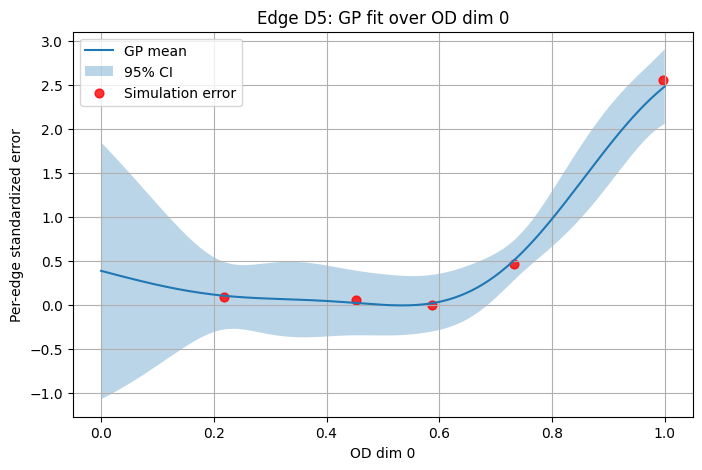

In [60]:
import torch
import matplotlib.pyplot as plt

# ---- Choose which edge to visualize ----
edge_to_plot = "D5"    # <-- put "L15" instead to visualize L15
# edge_to_plot = "L15"

# Find index of this edge
edge_idx = edge_ids.index(edge_to_plot)

# Extract the GP model for this edge
gp = model_list_gp_errors.models[edge_idx]
gp.eval()

# ---- Choose which OD dimension to visualize ----
dim_to_plot = 0   # 0, 1, 2, or 3
dim_names = [f"OD dim {i}" for i in range(train_X.shape[1])]

# Make a 1D grid for plotting
x_plot = torch.linspace(0, 1, 200).unsqueeze(-1)

# Create full input matrix (fix all other dims at their mean)
X_mean = train_X.mean(dim=0).unsqueeze(0)
X_plot = X_mean.repeat(200, 1)
X_plot[:, dim_to_plot] = x_plot.squeeze()

# Posterior predictions
posterior = gp.posterior(X_plot)
mean = posterior.mean.detach().numpy()
lower, upper = posterior.mvn.confidence_region()

# ---- Prepare raw data for this edge ----
y_raw = train_Y_errors[:, edge_idx].detach().numpy()
x_raw = train_X[:, dim_to_plot].detach().numpy()

# ---- Plot ----
plt.figure(figsize=(8, 5))

plt.plot(x_plot.numpy(), mean, label="GP mean")
plt.fill_between(
    x_plot.squeeze().numpy(),
    lower.detach().numpy(),
    upper.detach().numpy(),
    alpha=0.3,
    label="95% CI"
)

# Raw data points
plt.scatter(
    x_raw, y_raw,
    color='red',
    s=40,
    alpha=0.8,
    label="Simulation error"
)

plt.title(f"Edge {edge_to_plot}: GP fit over {dim_names[dim_to_plot]}")
plt.xlabel(dim_names[dim_to_plot])
plt.ylabel("Per-edge standardized error")
plt.legend()
plt.grid(True)
plt.show()

the plot shows how the D5 error changes when ONLY that OD variable changes.


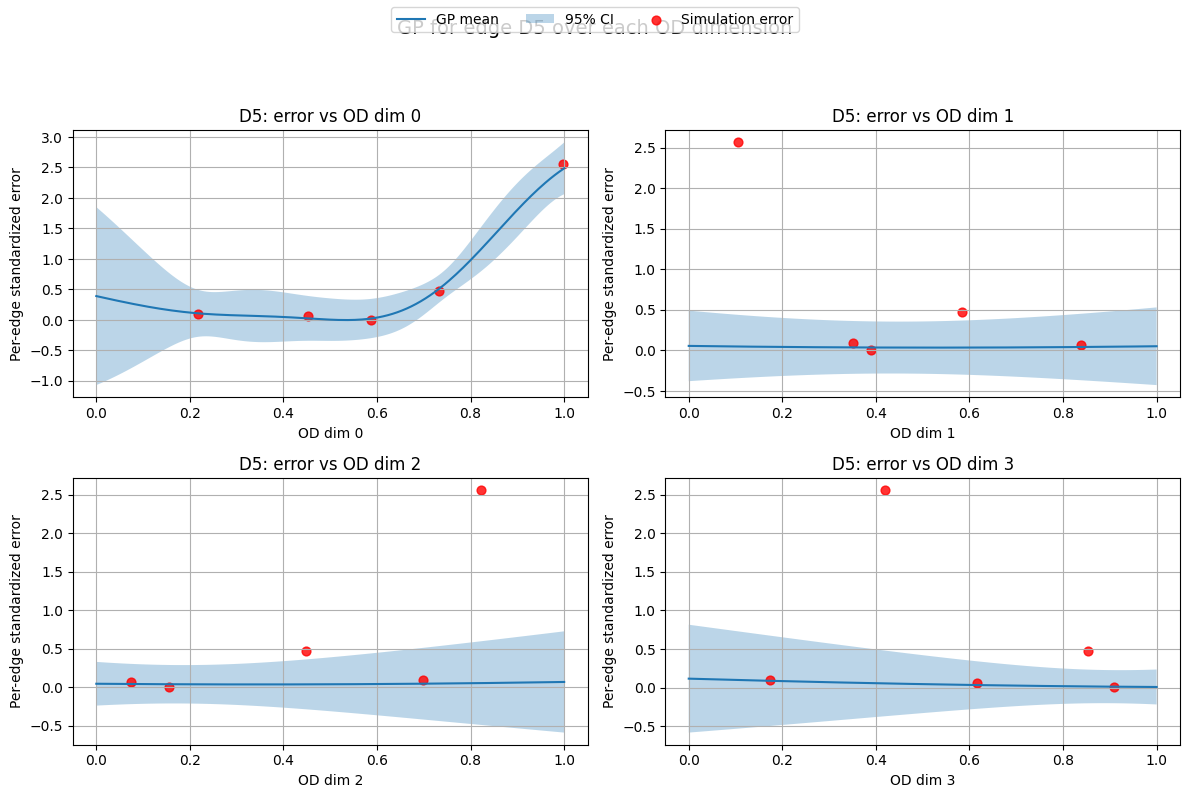

In [61]:
import torch
import matplotlib.pyplot as plt

# --------- Choose edge to visualize ----------
edge_to_plot = "D5"   # change to "L15", "D7", etc. if you want
edge_idx = edge_ids.index(edge_to_plot)

gp = model_list_gp_errors.models[edge_idx]
gp.eval()

n_dims = train_X.shape[1]
dim_labels = [f"OD dim {i}" for i in range(n_dims)]  # or replace with real OD names if you have them

X_mean = train_X.mean(dim=0).unsqueeze(0)  # (1, d)

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

for dim_to_plot in range(n_dims):
    # 1D grid for this dimension
    x_plot = torch.linspace(0, 1, 200).unsqueeze(-1)  # (200, 1)

    # Build full X_plot: all dims = mean, except this one
    X_plot = X_mean.repeat(200, 1)
    X_plot[:, dim_to_plot] = x_plot.squeeze()

    posterior = gp.posterior(X_plot)
    mean = posterior.mean.detach().numpy()
    lower, upper = posterior.mvn.confidence_region()

    # Raw data along this dim
    x_raw = train_X[:, dim_to_plot].detach().numpy()
    y_raw = train_Y_errors[:, edge_idx].detach().numpy()

    ax = axs[dim_to_plot]
    ax.plot(x_plot.numpy(), mean, label="GP mean")
    ax.fill_between(
        x_plot.squeeze().numpy(),
        lower.detach().numpy(),
        upper.detach().numpy(),
        alpha=0.3,
        label="95% CI"
    )
    ax.scatter(x_raw, y_raw, color="red", s=40, alpha=0.8, label="Simulation error")

    ax.set_title(f"{edge_to_plot}: error vs {dim_labels[dim_to_plot]}")
    ax.set_xlabel(dim_labels[dim_to_plot])
    ax.set_ylabel("Per-edge standardized error")
    ax.grid(True)

# One legend for all
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3)
fig.suptitle(f"GP for edge {edge_to_plot} over each OD dimension", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

They tell us that:
	•	D5 is highly sensitive to OD dimension 0
	•	And barely sensitive to dims 1, 2, 3
	•	So the GP is correct:
→ dims 1–3 should be flat functions
→ a point with high error is not due to dim1, but due to dim0

In [62]:
print(train_X_raw)

tensor([[1995.0267,  208.7328, 1645.9577,  838.8643],
        [ 905.4018, 1676.1346,  146.5409, 1232.3399],
        [ 436.3676,  700.4452, 1395.8535,  347.9317],
        [1463.9845, 1168.5940,  896.6126, 1706.4115],
        [1172.4651,  780.6038,  309.8300, 1819.2374]], dtype=torch.float64)


# computing aggregated nrmse for using it in the acquisition function 

In [66]:
#creating linear aggregation model from the trained GPs

import importlib
importlib.reload(helpers_od_calibration)
from helpers_od_calibration import make_linear_aggregation_model_from_error_gps

#computin gweight proportional to gt edge counts

observed_flows = gt_edge_data.set_index('edge_id').loc[edge_ids, 'interval_nVehContrib'].values

print(f"Total network flow: {observed_flows.sum():.0f} vehicles")


aggregated_gp_model = make_linear_aggregation_model_from_error_gps(
    model_list_gp_errors=model_list_gp_errors,
    weights=None, 
    ground_truth_flows= None 
)

print("Linear aggregation model created")
print(f"  Number of GPs: {len(aggregated_gp_model.models)}")
print(f"  Weights: {aggregated_gp_model.w}")
print(f"  Aggregation: S(x) = sum_l [w_l * e_l(x)]")

Total network flow: 18200 vehicles
Using uniform weights (1/14 each)
Linear aggregation model created
  Number of GPs: 14
  Weights: tensor([0.0714, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714,
        0.0714, 0.0714, 0.0714, 0.0714, 0.0714])
  Aggregation: S(x) = sum_l [w_l * e_l(x)]


In [67]:
# Use the SAME weights as in the aggregated GP
w = aggregated_gp_model.w.to(device=train_Y_errors.device, dtype=train_Y_errors.dtype) 

# S_obs(x_i) = sum_l w_l * e_l(x_i)
S_obs_train = (train_Y_errors * w).sum(dim=1)    

best_S = S_obs_train.min().item()
best_idx = S_obs_train.argmin()

best_od = unnormalize(train_X[best_idx:best_idx+1], bounds).squeeze().cpu().numpy()

print(f"Best observed S(x): {best_S:.6f}")
print(f"\nBest training OD:")
for i, val in enumerate(best_od):
    print(f"  OD {i}: {val:.0f}")


Best observed S(x): 0.066142

Best training OD:
  OD 0: 436
  OD 1: 700
  OD 2: 1396
  OD 3: 348


S(x) = Σ_l w_l × e_l(x)

where:
- e_l(x) = (predicted_l(x) - observed_l)² / observed_l²  ← Squared relative error for edge l
- w_l = flow_l / Σ_l flow_l  ← Flow-proportional weight for edge l
- L = 14 edges in your network

In words:
S(x) = "Flow-weighted average of squared relative errors across all edges"

In [68]:
# OPTIMIZE ACQUISITION FUNCTION (EXPECTED IMPROVEMENT)

from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf 
import numpy as np

# Create EI acquisition function
EI = ExpectedImprovement(
    model=aggregated_gp_model, #should preduct s(x) which is the weighted sum of per-edge errors
    best_f=best_S,  # Best observed S(x)
    maximize=False  # Minimize S(x)
)


# Optimize in normalized [0,1] space
d = train_X.shape[1]  # Number of OD pairs
acq_bounds = torch.stack([
    torch.zeros(d, device=device, dtype=dtype),
    torch.ones(d, device=device, dtype=dtype)
])

print(f"  Dimension: {d}")

#candidate points for testing, next evaluation
candidates, acq_val = optimize_acqf(
    acq_function=EI,
    bounds=acq_bounds, # making sure that demand is within [0,1], normalized space
    q=1, # number of candidates to propose
    num_restarts=20, # of random initial conditions
    raw_samples=512, # number of samples for initialization
    options={"batch_limit": 5, "maxiter": 200},
)

X_next_norm = candidates.detach()  # (1, d) normalized
X_next_real = unnormalize(X_next_norm, bounds)  # back to OD units

print(f"Optimization complete")



/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Dimension: 4
Optimization complete


In [69]:
# EVALUATE PREDICTION AT NEW POINT
with torch.no_grad():
    post_next = aggregated_gp_model.posterior(X_next_norm)
    pred_S_mean_tensor = post_next.mean
    pred_S_var_tensor = post_next.variance
    
    if pred_S_mean_tensor.dim() > 0:
        pred_S_mean = pred_S_mean_tensor.squeeze().item()
    else:
        pred_S_mean = pred_S_mean_tensor.item()
    
    if pred_S_var_tensor.dim() > 0:
        pred_S_var = pred_S_var_tensor.squeeze().item()
    else:
        pred_S_var = pred_S_var_tensor.item()
    
    pred_S_std = np.sqrt(pred_S_var)
    #pred_RMSRE = np.sqrt(pred_S_mean)

next_od = X_next_real.squeeze().cpu().numpy()

print(f"Next OD candidate (normalized):")
print(f"  {X_next_norm.squeeze().cpu().numpy()}")
print(f"\nNext OD candidate (original scale):")
for i in range(len(next_od)):
    print(f"  OD {i}: {next_od[i]:8.0f}")


print(f"\nPredicted performance:")
print(f"  S(x):       {pred_S_mean:.6f} ± {pred_S_std:.6f}")
#print(f"  NRMSE:      {pred_RMSRE:.6f}")

print(f"\nBest observed (training):")
print(f"  S(x):       {best_S:.6f}")
#print(f"  NRMSE:      {np.sqrt(best_S):.6f}")

print(f"\nExpected improvement:")
improvement = max(0, best_S - pred_S_mean)
print(f"  ΔS(x):      {improvement:.6f}")
print(f"  EI value:   {acq_val.item():.6f}")

if pred_S_mean < best_S:
    print(f"\n GP predicts this will be better than best training sample!")
    print(f"   Expected improvement: {(best_S - pred_S_mean):.10f}")
else:
    print(f"\n GP predicts this might not be better (exploring uncertain region)")


Next OD candidate (normalized):
  [0.07446646 0.31931405 0.69219863 0.29104039]

Next OD candidate (original scale):
  OD 0:      149
  OD 1:      639
  OD 2:     1384
  OD 3:      582

Predicted performance:
  S(x):       0.116593 ± 0.107185

Best observed (training):
  S(x):       0.066142

Expected improvement:
  ΔS(x):      0.000000
  EI value:   0.022186

 GP predicts this might not be better (exploring uncertain region)


# addidn the complete BO LOOP 

In [77]:
import importlib
import helpers_od_calibration

importlib.reload(helpers_od_calibration)

from helpers_od_calibration import (
    initialize_independent_gp_models_with_modellist,
    BayesianOptimizationLoop,
    run_multiple_bo_restarts,
    #visualize_bo_results,
    #visualize_multiple_restarts,
    #save_bo_results_to_csv,
    plot_flow_coverage_per_edge,
    plot_best_iteration_like_prof,
    plot_iteration_like_prof,
    plot_all_iterations_like_prof,
    plot_od_comparison_per_iteration,
)


#continuing from the best found
bo_loop = BayesianOptimizationLoop(
    config=config,
    gt_edge_data=gt_edge_data,
    edge_ids=edge_ids,
    gt_od_vals=gt_od_vals,
    routes_df=routes_df,
    base_path=base_path,
    bounds=bounds,
    device=device,
    dtype=dtype,
)


BO Framework initialized
  Edges: 14
  OD dimension: 4


In [78]:
from helpers_od_calibration import plot_flow_coverage_per_edge

results = bo_loop.run_bo_loop(
    train_X_init=train_X,          # existing normalized data
    train_Y_errors_init=train_Y_errors,
    n_iterations=10,               # or 15, but pick ONE value
)



STARTING BAYESIAN OPTIMIZATION LOOP

Initial training data: 5 samples
Initial best S: 0.058912 (NRMSE: 0.242718)

BO ITERATION 1/10

Step 1: Update GP models
  Refitting GPs with 5 samples...
Using flow-proportional weights (based on 18200.0 total veh/h)

Step 2: Optimize acquisition function
  Current best S: 0.058912


/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.019092
  GP predicts S: 0.059594 ± 0.048705

Step 3: Run SUMO simulation
  OD (real): [ 544.75514588  621.25803903 1409.08072687    0.        ]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2575.0939117725156
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_5/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_5/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_5/sim_trips_beforeRteUpdates.xml
Success.time 299.25
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_5/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Deskto

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.052910
  GP predicts S: 0.006546 ± 0.030597

Step 3: Run SUMO simulation
  OD (real): [ 309.89010221  620.88821371 1388.54667351  602.33604675]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2921.661036180356
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_6/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_6/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_6/sim_trips_beforeRteUpdates.xml
Success.time 299.76
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_6/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.023721
  GP predicts S: 0.035476 ± 0.014124

Step 3: Run SUMO simulation
  OD (real): [ 509.35489651  653.52118112 1407.81462562  500.7315399 ]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 3071.422243144808
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_7/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_7/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_7/sim_trips_beforeRteUpdates.xml
Success.time 299.47
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_7/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.056315
  GP predicts S: 0.010905 ± 0.063716

Step 3: Run SUMO simulation
  OD (real): [226.96052304 679.81020731 421.88880281 415.69383855]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 1744.3533717164332
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_8/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_8/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_8/sim_trips_beforeRteUpdates.xml
Success.time 299.34
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_8/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/Su

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.019570
  GP predicts S: 0.039607 ± 0.011926

Step 3: Run SUMO simulation
  OD (real): [ 250.59266307  668.6808493  1399.72281787  354.92008241]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2673.9164126539044
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_9/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_9/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_9/sim_trips_beforeRteUpdates.xml
Success.time 299.04
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_9/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Deskto

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.053104
  GP predicts S: 0.006145 ± 0.028219

Step 3: Run SUMO simulation
  OD (real): [397.12402589 674.0990175    0.         779.2692868 ]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 1850.49233018929
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_10/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_10/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_10/sim_trips_beforeRteUpdates.xml
Success.time 299.62
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_10/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Desktop/

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.021083
  GP predicts S: 0.037909 ± 0.010314

Step 3: Run SUMO simulation
  OD (real): [ 407.28843427  680.26312696 1253.26467734  577.16829796]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2917.9845365266947
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_11/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_11/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_11/sim_trips_beforeRteUpdates.xml
Success.time 299.16
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_11/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/De

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.002702
  GP predicts S: 0.057624 ± 0.004993

Step 3: Run SUMO simulation
  OD (real): [ 418.20841303  661.68806717 1292.72264919  443.7930865 ]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2816.412215899779
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_12/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_12/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_12/sim_trips_beforeRteUpdates.xml
Success.time 299.88
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_12/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Des

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.013108
  GP predicts S: 0.047676 ± 0.014672

Step 3: Run SUMO simulation
  OD (real): [ 426.18237452  738.60340493 1343.88583198  518.4759925 ]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 3027.147603924733
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_13/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_13/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_13/sim_trips_beforeRteUpdates.xml
Success.time 299.80
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_13/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/Des

/Users/inesbenhamza/Desktop/Sumo_od_calibration/env/lib/python3.12/site-packages/botorch/acquisition/analytic.py:340: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


  Acquisition value (EI): 0.018104
  GP predicts S: 0.042472 ± 0.017616

Step 3: Run SUMO simulation
  OD (real): [ 396.10384384  477.96196107 1172.27840614  712.23363226]
  Creating OD with TAZ pairs: [['taz91', 'taz94'], ['taz91', 'taz93'], ['taz92', 'taz93'], ['taz92', 'taz94']]
total expected GT demand: 2758.5778433190144
Created  /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_14/od.xml
od2trips  --spread.uniform --taz-files /Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/taz.xml --tazrelation-files output/quickstart_bo_vanilla/bo_iter_14/od.xml -o /Users/inesbenhamza/Desktop/Sumo_od_calibration/output/quickstart_bo_vanilla/bo_iter_14/sim_trips_beforeRteUpdates.xml
Success.time 299.10
###### Running SUMO #######
Seed 0
sumo --output-prefix output/quickstart_bo_vanilla/bo_iter_14/sim_ --ignore-route-errors=true --net-file=/Users/inesbenhamza/Desktop/Sumo_od_calibration/network/quickstart/net.xml --routes=/Users/inesbenhamza/De

# result analysis 

In [72]:
plot_flow_coverage_per_edge(
    df_edge_stats=results.df_edge_stats,
    gt_edge_data=gt_edge_data,
    edge_ids=edge_ids,
    save_path=f"{config['simulation_run_path']}/figs/flow_coverage_per_edge.png",
)

NameError: name 'results' is not defined

In [86]:
visualize_bo_results(
    results=results,
    save_dir=f"{config['simulation_run_path']}/figs",
    bounds=bounds,
    gt_od_vals=gt_od_vals,
)

Saved visualization: output/quickstart_bo_vanilla/figs/bo_results_comprehensive.png


Best BO iteration index: 14


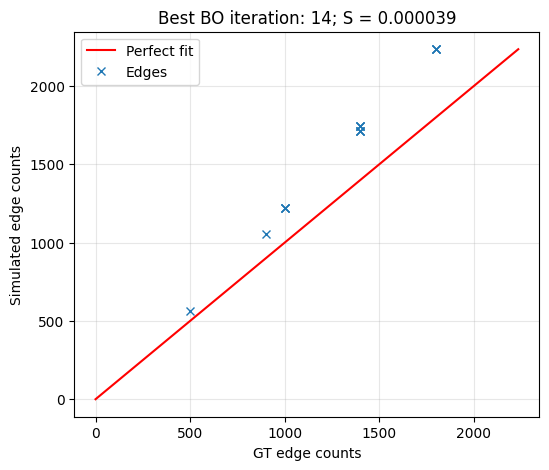

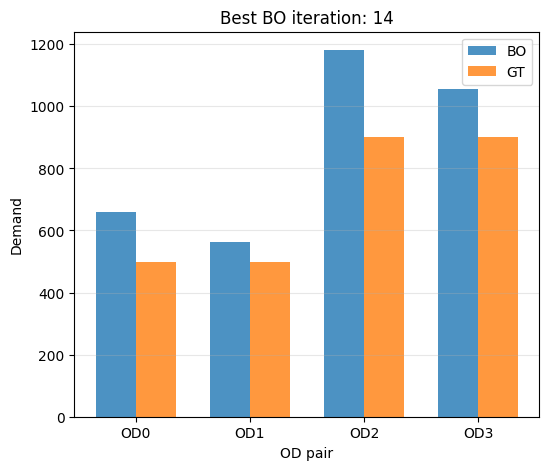

In [87]:
plot_best_iteration_like_prof(
    results=results,
    gt_edge_data=gt_edge_data,
    edge_ids=edge_ids,
    gt_od_vals=gt_od_vals,
    bounds=bounds,
    save_dir=f"{config['simulation_run_path']}/figs",
)

In [81]:
gt_edge_data["edge_id"].unique()

array(['D4', 'L14', 'L4', 'D5', 'D7', 'L10', 'L18', 'L5', 'L7', 'D2',
       'L12', 'L2', 'L16', 'L15'], dtype=object)

Plotting 15 evaluations (0..14)
[plot] No edge stats for eval_idx 0 – skipping.
[plot] No edge stats for eval_idx 1 – skipping.
[plot] No edge stats for eval_idx 2 – skipping.
[plot] No edge stats for eval_idx 3 – skipping.
[plot] No edge stats for eval_idx 4 – skipping.
Saved output/quickstart_bo_vanilla/figs/bo_eval_05_prof_style.png


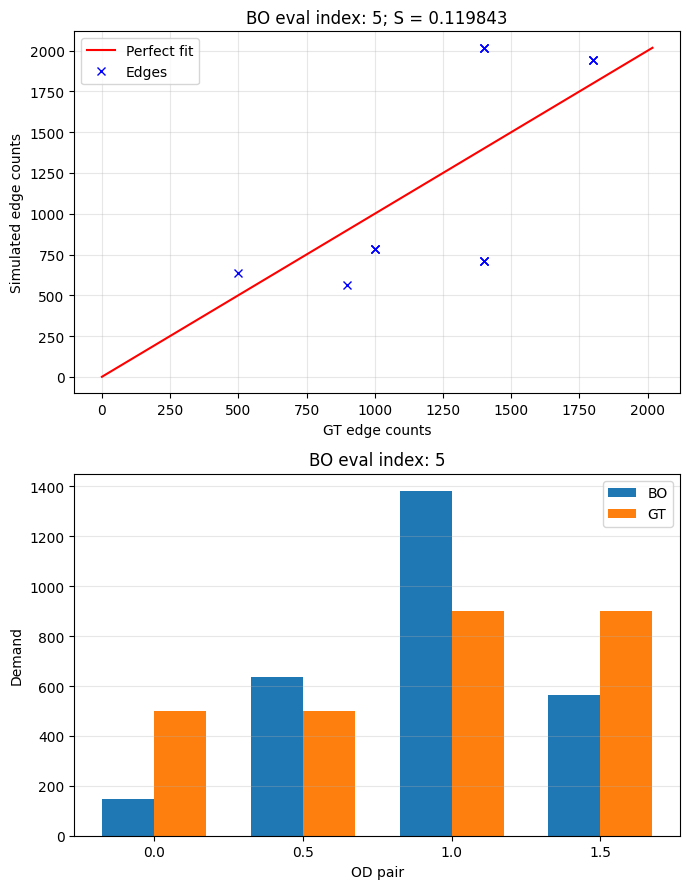

Saved output/quickstart_bo_vanilla/figs/bo_eval_06_prof_style.png


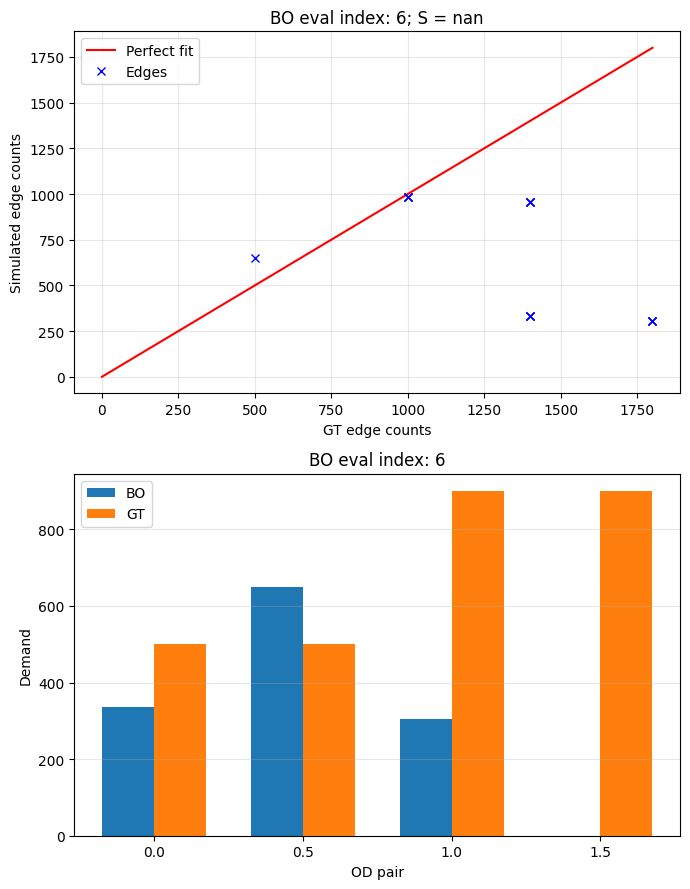

Saved output/quickstart_bo_vanilla/figs/bo_eval_07_prof_style.png


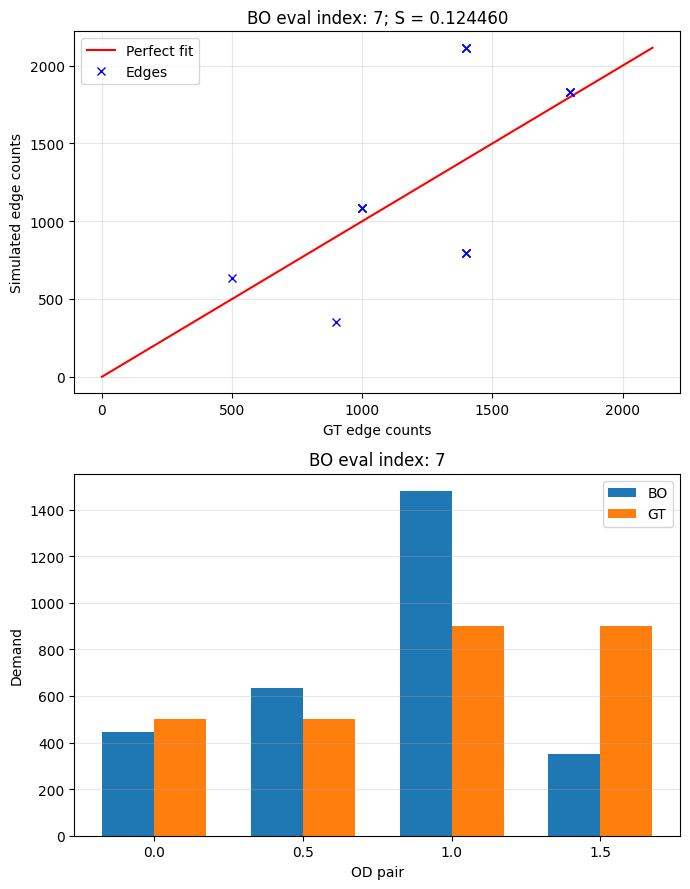

Saved output/quickstart_bo_vanilla/figs/bo_eval_08_prof_style.png


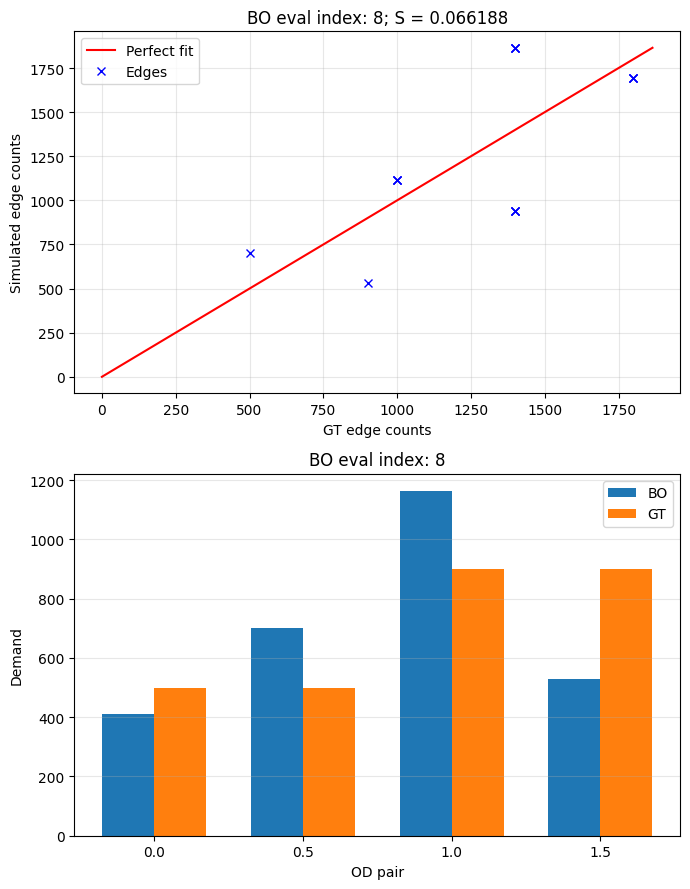

Saved output/quickstart_bo_vanilla/figs/bo_eval_09_prof_style.png


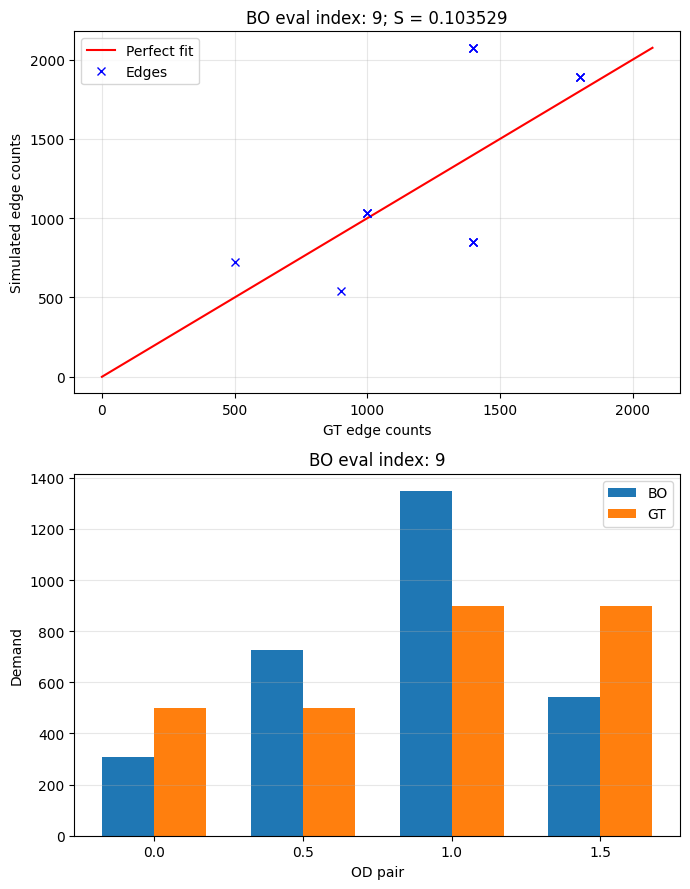

Saved output/quickstart_bo_vanilla/figs/bo_eval_10_prof_style.png


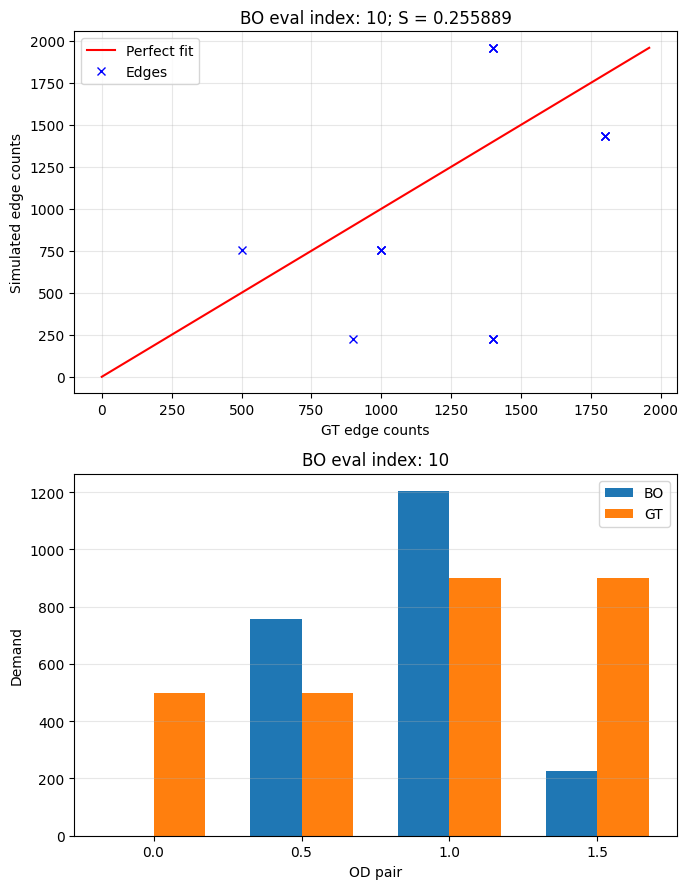

Saved output/quickstart_bo_vanilla/figs/bo_eval_11_prof_style.png


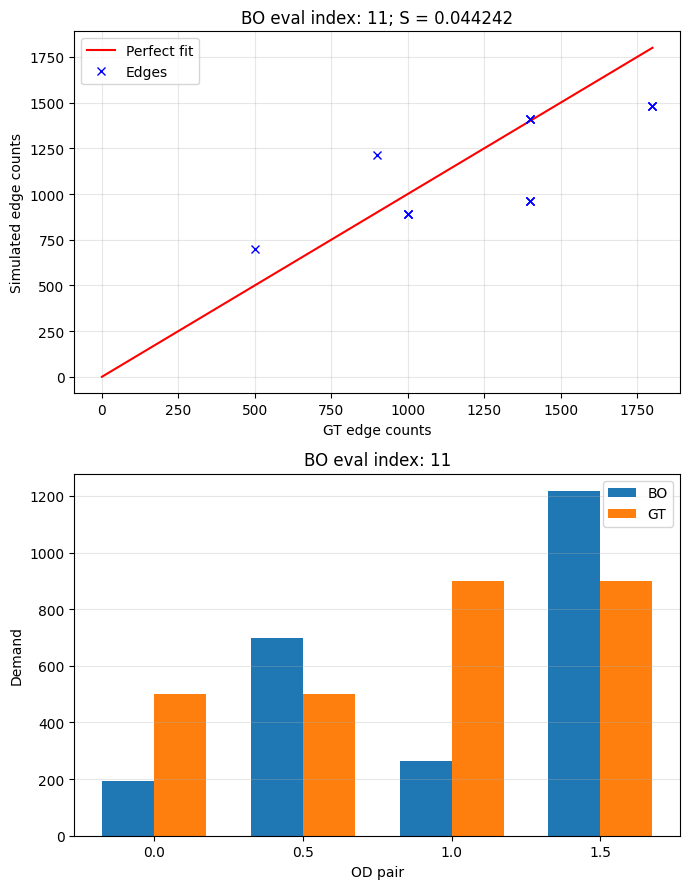

Saved output/quickstart_bo_vanilla/figs/bo_eval_12_prof_style.png


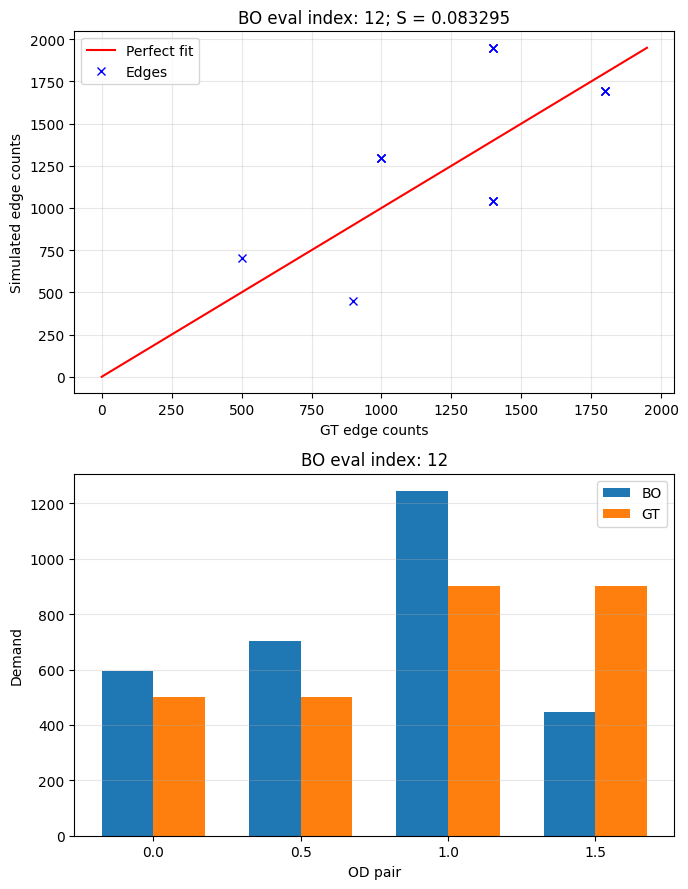

Saved output/quickstart_bo_vanilla/figs/bo_eval_13_prof_style.png


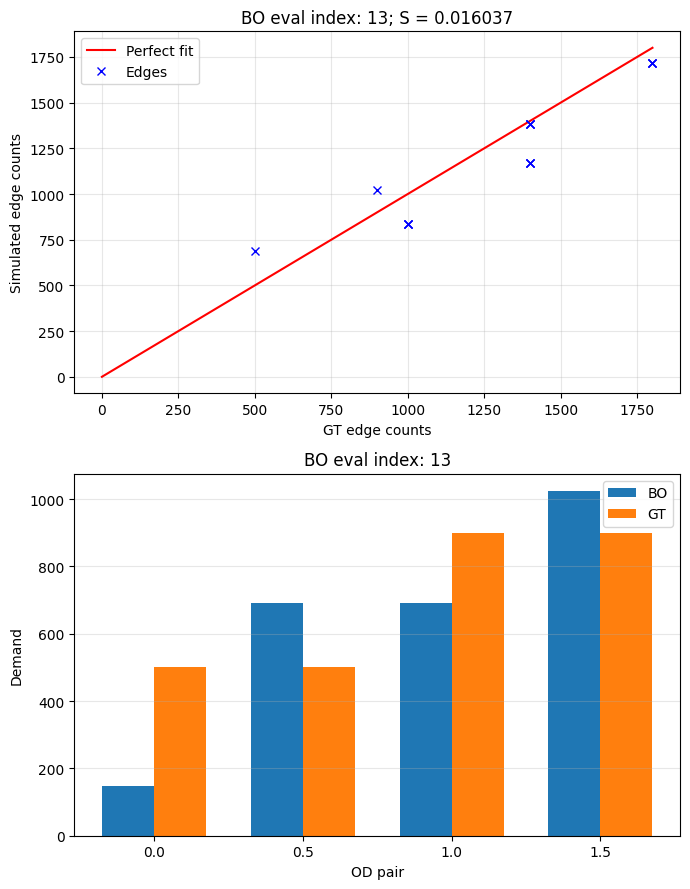

Saved output/quickstart_bo_vanilla/figs/bo_eval_14_prof_style.png


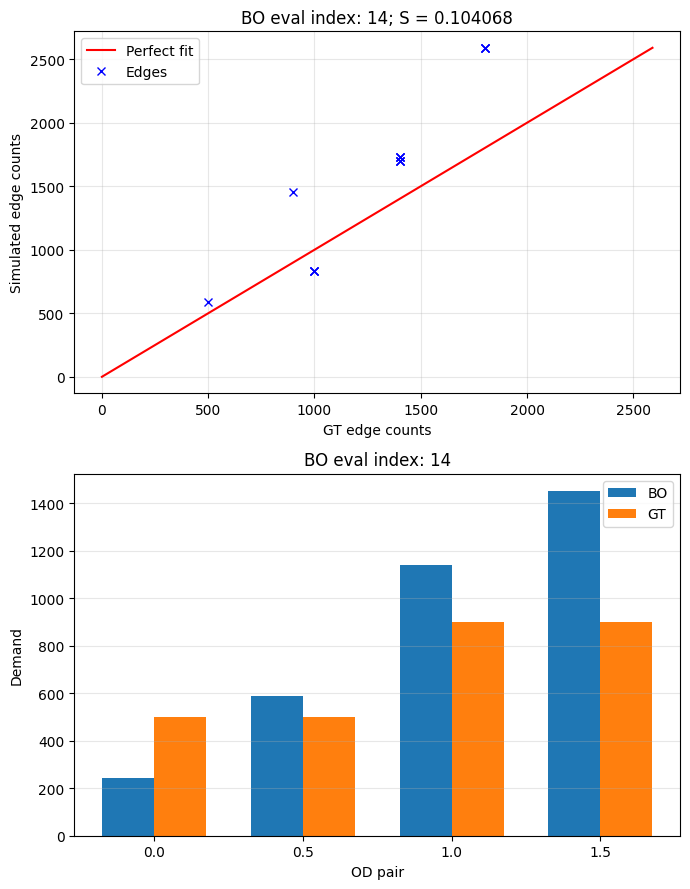

In [79]:
plot_all_iterations_like_prof(
    results=results,
    gt_edge_data=gt_edge_data,
    edge_ids=edge_ids,
    gt_od_vals=gt_od_vals,
    bounds=bounds,
    save_dir=f"{config['simulation_run_path']}/figs",
)


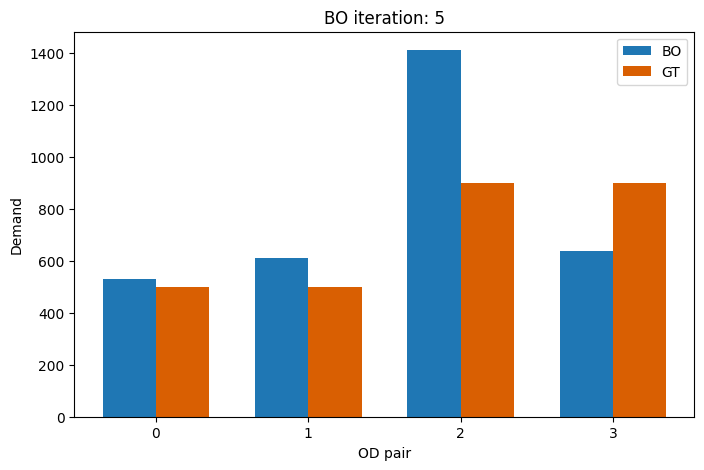

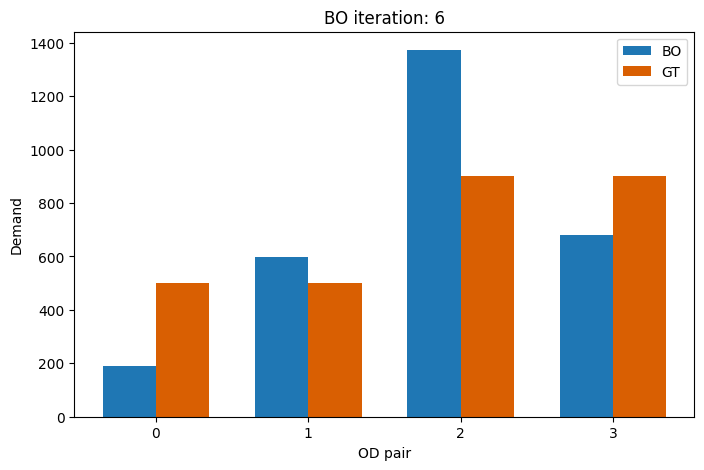

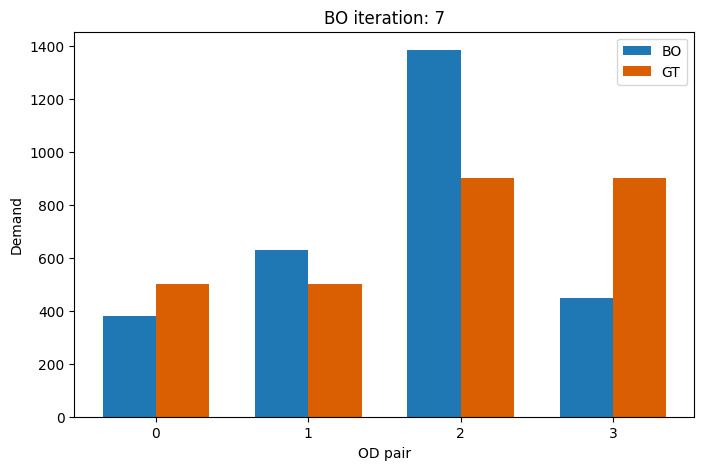

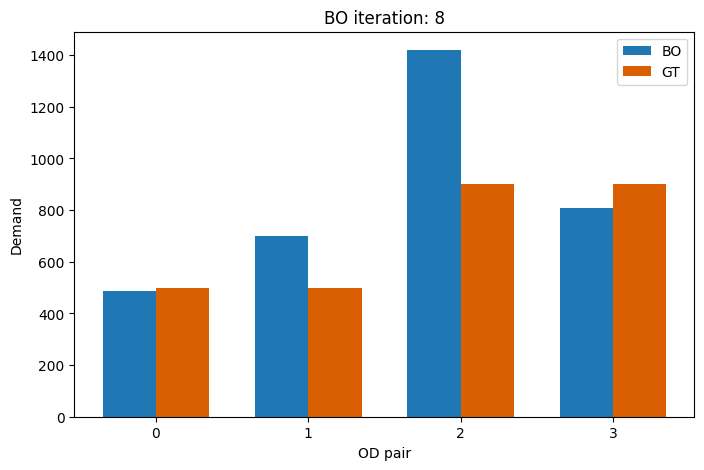

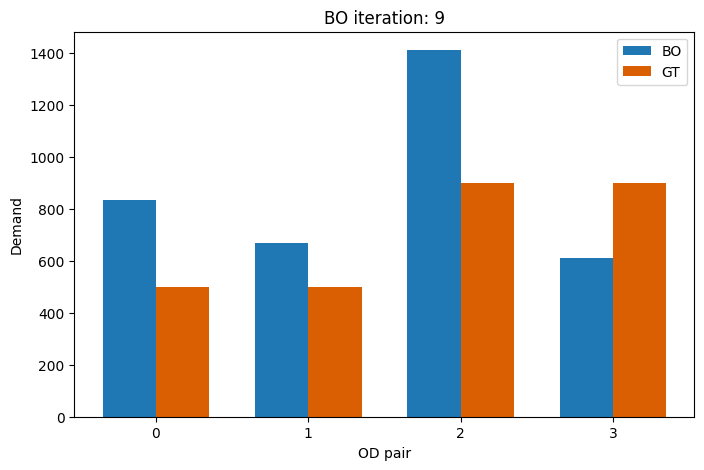

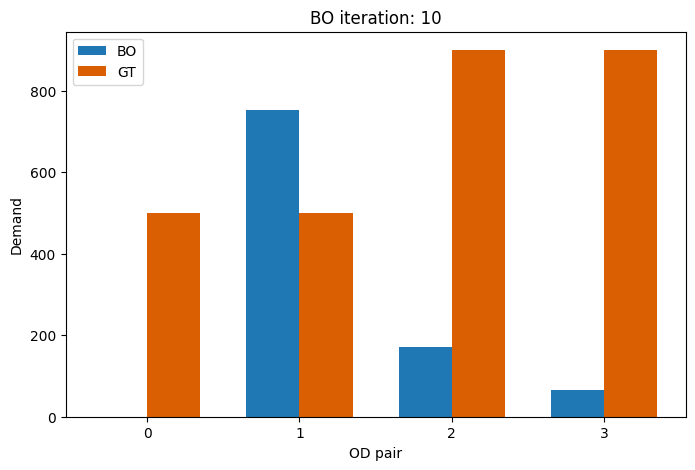

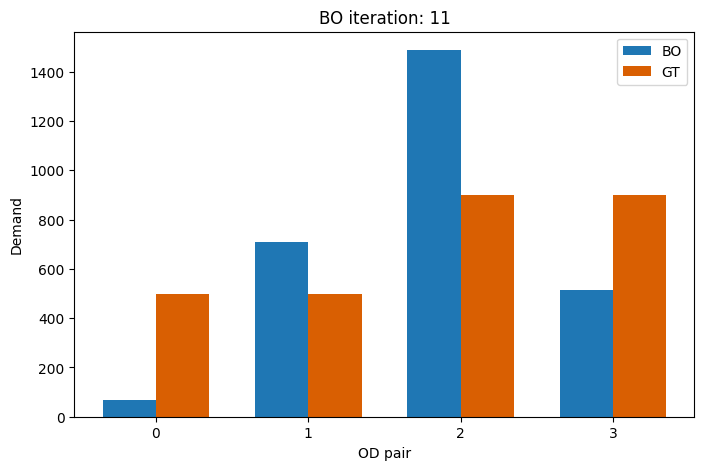

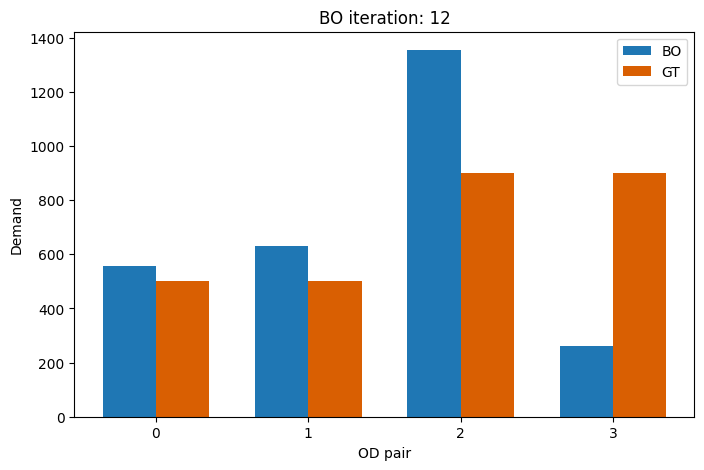

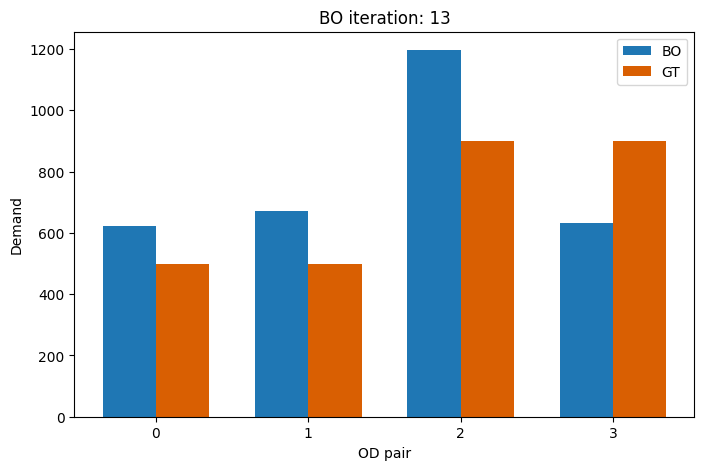

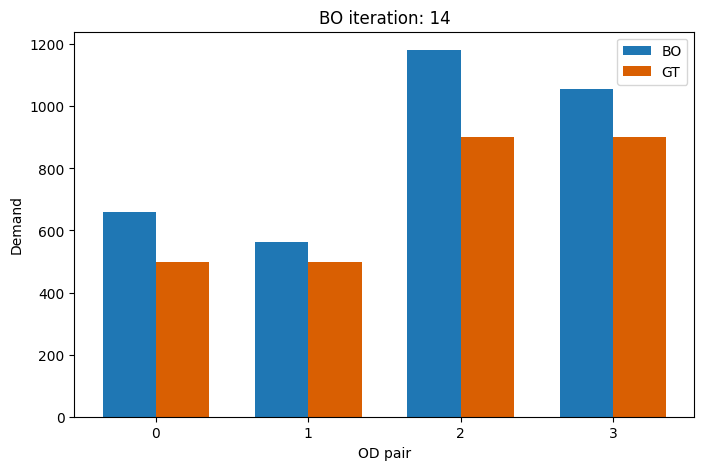

In [88]:
plot_od_comparison_per_iteration(
    results=results,
    gt_od_vals=gt_od_vals,
    bounds=bounds,
    save_dir=f"{config['simulation_run_path']}/figs"
)

In [73]:
def plot_convergence_bo_only(results, save_path=None):
    """
    Plot convergence curve showing ONLY the BO iterations.
    Initial samples are removed.
    """

    S_all = results.all_S.cpu().numpy()
    start = results.iteration_start        # number of initial samples

    # Extract only BO iterations
    S_bo = S_all[start:]                   # shape (n_bo_iterations,)
    iters_bo = np.arange(1, len(S_bo) + 1)

    # Best-so-far only within BO phase
    best_so_far = np.minimum.accumulate(S_bo)

    plt.figure(figsize=(10, 5))
    plt.plot(iters_bo, S_bo, marker="o", linewidth=2,
             label="S(x) per BO iteration")
    plt.plot(iters_bo, best_so_far, "--", linewidth=2,
             label="Best-so-far")

    plt.xlabel("BO iteration number")
    plt.ylabel("Aggregated squared error S(x)")
    plt.title("BO Convergence Curve (BO iterations only)")
    plt.grid(True, alpha=0.3)
    plt.legend()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Saved plot to {save_path}")

    plt.show()



plot_convergence_bo_only(
    results,
    save_path=f"{config['simulation_run_path']}/figs/convergence_bo_only.png"
)

NameError: name 'results' is not defined

In [91]:
print("per_edge_errors:", per_edge_errors)
print("weights:", weights)
print("curr_loss S(x):", curr_loss)

per_edge_errors: [9.06304000e-04 1.85598422e-05 2.45043732e-06 5.23907070e-04
 5.23907070e-04 9.06304000e-04 1.85598422e-05 3.61267200e-03
 1.15851989e-03 2.45043732e-06 9.06304000e-04 1.85598422e-05
 2.45043732e-06 5.23907070e-04]
weights: [0.05494506 0.0989011  0.07692308 0.07692308 0.07692308 0.05494506
 0.0989011  0.02747253 0.04945055 0.07692308 0.05494506 0.0989011
 0.07692308 0.07692308]
curr_loss S(x): 0.6054400815173144


# BO WITH MULTIPLE RESTART

In [74]:
# Visualize
visualize_bo_results(
    results, 
    save_dir=f"{config['simulation_run_path']}/bo_results",
    bounds=bounds,
    gt_od_vals=gt_od_vals
)

# Save
save_bo_results_to_csv(
    results, 
    save_path=f"{config['simulation_run_path']}/bo_results/bo_results.csv",
    bounds=bounds
)

print("\nSingle BO run complete!")

# ============================================
# OPTION 2: Multiple Restarts with Mean/Std
# ============================================

print("\n" + "="*70)
print("OPTION 2: MULTIPLE BO RESTARTS")
print("="*70)

aggregated_results = run_multiple_bo_restarts(
    config=config,
    gt_edge_data=gt_edge_data,
    edge_ids=edge_ids,
    gt_od_vals=gt_od_vals,
    routes_df=routes_df,
    base_path=base_path,
    bounds=bounds,
    device=device,
    dtype=dtype,
    n_restarts=3,  # Run BO 3 times
    n_init_per_restart=5,  # 5 Sobol samples each
    n_bo_iterations=15  # 15 BO iterations each
)

# Visualize aggregated results
visualize_multiple_restarts(
    aggregated_results,
    save_dir=f"{config['simulation_run_path']}/bo_results"
)

# Save best result
best_result = aggregated_results['overall_best_result']
save_bo_results_to_csv(
    best_result,
    save_path=f"{config['simulation_run_path']}/bo_results/best_bo_result.csv",
    bounds=bounds
)

print("\n" + "="*70)
print("ALL BO ANALYSIS COMPLETE!")
print("="*70)
print(f"\nCheck results in: {config['simulation_run_path']}/bo_results/")

NameError: name 'visualize_bo_results' is not defined

In [49]:
# In your notebook - AFTER running BO

# 1. Visualize results
visualize_bo_results(
    results=results,
    save_dir=config['simulation_run_path'],  # Or any directory you want
    bounds=bounds,
    gt_od_vals=gt_od_vals
)

# 2. Save results to CSV
save_bo_results_to_csv(
    results=results,
    save_path=f"{config['simulation_run_path']}/bo_results.csv",
    bounds=bounds
)

# 3. Print summary
print(f"\n{'='*70}")
print("FINAL RESULTS SUMMARY")
print(f"{'='*70}")
print(f"Best S(x): {results.best_S:.6f}")
print(f"Best NRMSE: {np.sqrt(results.best_S):.4f}")
print(f"Best iteration: {results.best_idx}")
print(f"\nBest OD matrix (unnormalized):")
best_od = unnormalize(results.best_X.unsqueeze(0), bounds).squeeze().cpu().numpy()
print(best_od)
print(f"\nGround truth OD:")
print(gt_od_vals)
print(f"\nDifference:")
print(best_od - gt_od_vals)
print(f"\nRelative error per OD pair:")
print((best_od - gt_od_vals) / gt_od_vals * 100)

Saved visualization: output/quickstart_bo_vanilla/bo_results_comprehensive.png
Saved results to output/quickstart_bo_vanilla/bo_results.csv

FINAL RESULTS SUMMARY
Best S(x): 0.000003
Best NRMSE: 0.0018
Best iteration: 17

Best OD matrix (unnormalized):
[531.87589662 557.44110365 807.79952945 968.08626308]

Ground truth OD:
[500. 500. 900. 900.]

Difference:
[ 31.87589662  57.44110365 -92.20047055  68.08626308]

Relative error per OD pair:
[  6.37517932  11.48822073 -10.24449673   7.56514034]


Saved convergence plot: output/quickstart_bo_vanilla/bo_convergence.png


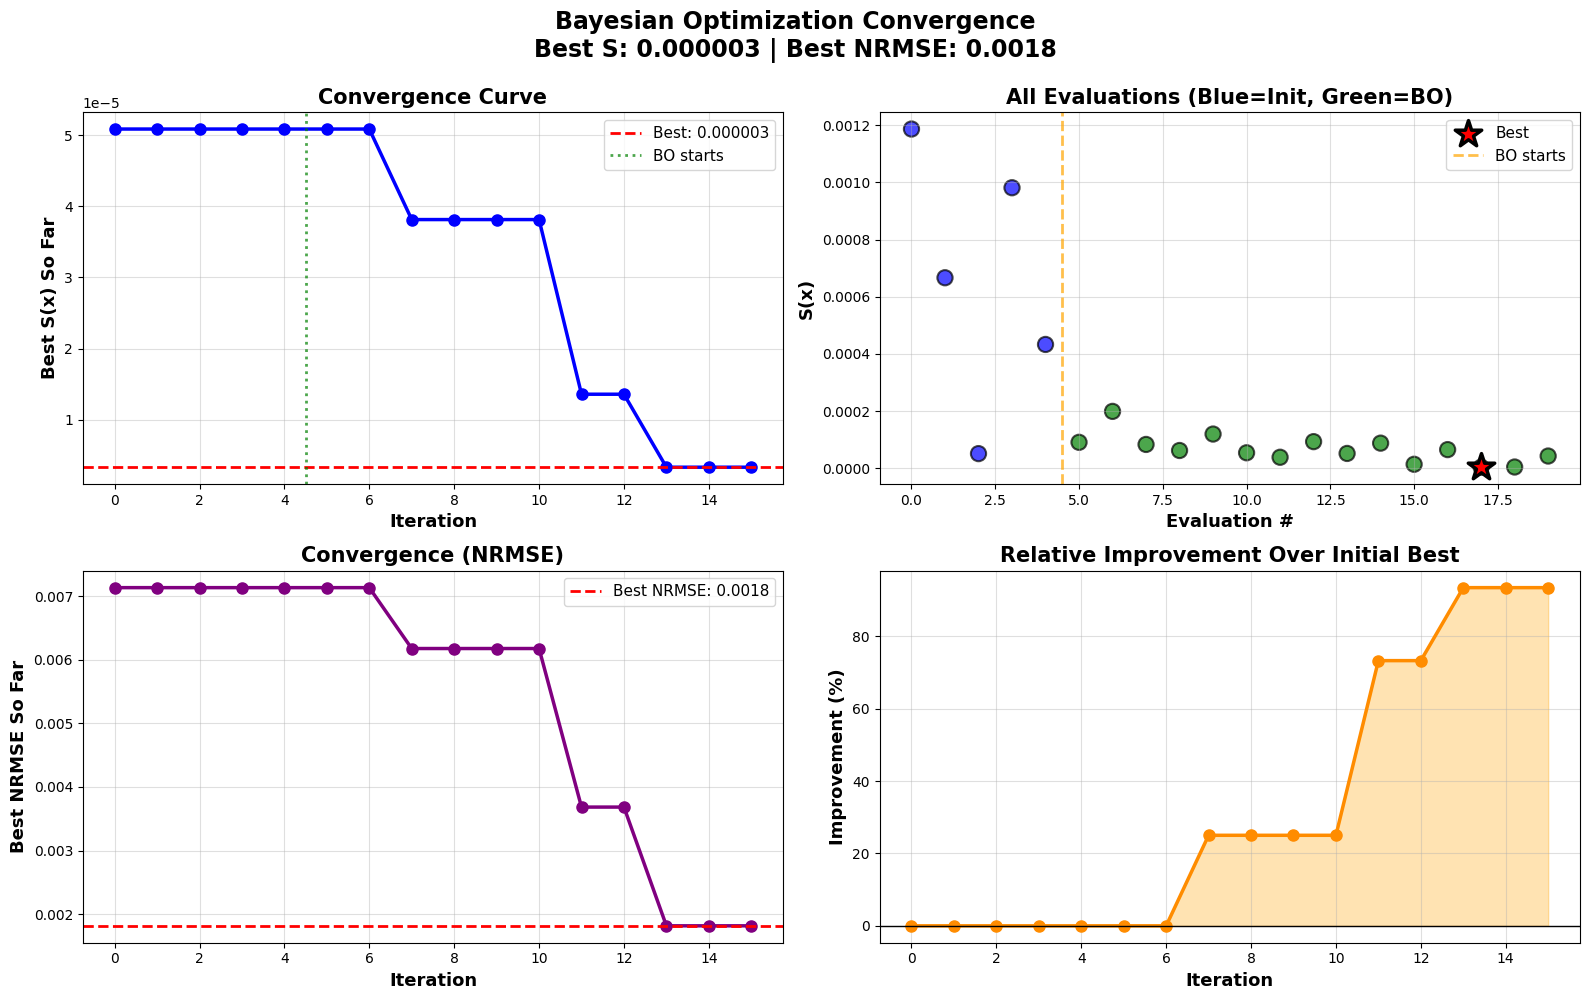

In [50]:
# In your notebook - AFTER running BO

import matplotlib.pyplot as plt
import numpy as np

# Create convergence plot
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Convergence curve (best-so-far)
ax = axes[0, 0]
iterations = np.arange(len(results.convergence_curve))
ax.plot(iterations, results.convergence_curve, 'b-o', linewidth=2.5, markersize=8)
ax.axhline(results.best_S, color='red', linestyle='--', linewidth=2, 
           label=f'Best: {results.best_S:.6f}')
ax.axvline(results.iteration_start - 0.5, color='green', linestyle=':', 
           linewidth=2, alpha=0.7, label='BO starts')
ax.set_xlabel('Iteration', fontsize=13, fontweight='bold')
ax.set_ylabel('Best S(x) So Far', fontsize=13, fontweight='bold')
ax.set_title('Convergence Curve', fontsize=15, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.4)

# 2. All observed S values (scatter)
ax = axes[0, 1]
all_S = results.all_S.cpu().numpy()
colors = ['blue'] * results.iteration_start + ['green'] * len(results.acq_values)
ax.scatter(range(len(all_S)), all_S, c=colors, s=120, alpha=0.7, 
           edgecolors='black', linewidths=1.5)
ax.scatter(results.best_idx, results.best_S, c='red', s=400, marker='*', 
           edgecolors='black', linewidths=2.5, label='Best', zorder=10)
ax.axvline(results.iteration_start - 0.5, color='orange', linestyle='--', 
           linewidth=2, alpha=0.7, label='BO starts')
ax.set_xlabel('Evaluation #', fontsize=13, fontweight='bold')
ax.set_ylabel('S(x)', fontsize=13, fontweight='bold')
ax.set_title('All Evaluations (Blue=Init, Green=BO)', fontsize=15, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.4)

# 3. Convergence in NRMSE
ax = axes[1, 0]
nrmse_curve = [np.sqrt(s) for s in results.convergence_curve]
ax.plot(iterations, nrmse_curve, 'purple', linewidth=2.5, marker='o', markersize=8)
ax.axhline(np.sqrt(results.best_S), color='red', linestyle='--', linewidth=2, 
           label=f'Best NRMSE: {np.sqrt(results.best_S):.4f}')
ax.set_xlabel('Iteration', fontsize=13, fontweight='bold')
ax.set_ylabel('Best NRMSE So Far', fontsize=13, fontweight='bold')
ax.set_title('Convergence (NRMSE)', fontsize=15, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.4)

# 4. Improvement over iterations
ax = axes[1, 1]
initial_best = results.convergence_curve[0]
improvements = [(initial_best - s)/initial_best * 100 for s in results.convergence_curve]
ax.plot(iterations, improvements, 'darkorange', linewidth=2.5, marker='o', markersize=8)
ax.axhline(0, color='black', linestyle='-', linewidth=1)
ax.set_xlabel('Iteration', fontsize=13, fontweight='bold')
ax.set_ylabel('Improvement (%)', fontsize=13, fontweight='bold')
ax.set_title('Relative Improvement Over Initial Best', fontsize=15, fontweight='bold')
ax.grid(True, alpha=0.4)
ax.fill_between(iterations, 0, improvements, alpha=0.3, color='orange')

plt.suptitle(f'Bayesian Optimization Convergence\nBest S: {results.best_S:.6f} | Best NRMSE: {np.sqrt(results.best_S):.4f}', 
             fontsize=17, fontweight='bold', y=0.995)
plt.tight_layout()

# Save
save_path = f"{config['simulation_run_path']}/bo_convergence.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Saved convergence plot: {save_path}")
plt.show()


INSPECT THE SOLUTION

Best Solution Found at Iteration: 17
Best S(x): 0.000003
Best NRMSE: 0.0018

OD Pair         Ground Truth    Best Found      Difference      Rel Error %    
---------------------------------------------------------------------------
0               500.0           531.9           31.9            6.38           
1               500.0           557.4           57.4            11.49          
2               900.0           807.8           -92.2           -10.24         
3               900.0           968.1           68.1            7.57           


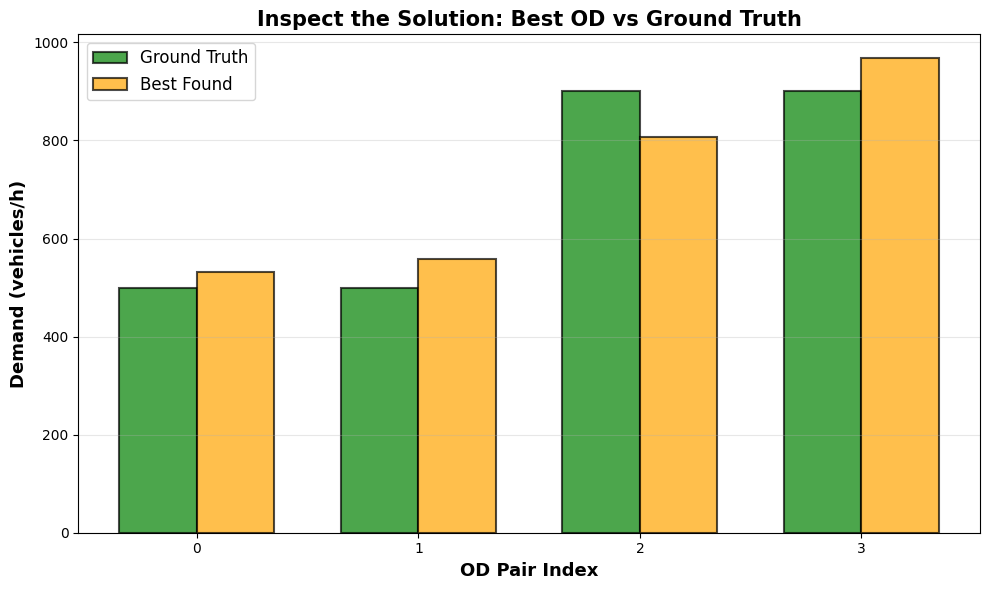


TRAJECTORY OF DISCREPANCY DECREASE

Initial best S:       0.000051
Final best S:         0.000003
Absolute improvement: 0.000048
Relative improvement: 93.50%

Iteration-by-iteration progress:
Iteration    Best S(x)       Best NRMSE      Status              
--------------------------------------------------------------
0            0.000051        0.0071                              
1            0.000051        0.0071                              
2            0.000051        0.0071                              
3            0.000051        0.0071                              
4            0.000051        0.0071                              
5            0.000051        0.0071                              
6            0.000051        0.0071                              
7            0.000038        0.0062          ★ NEW BEST          
8            0.000038        0.0062                              
9            0.000038        0.0062                              
10           0.000

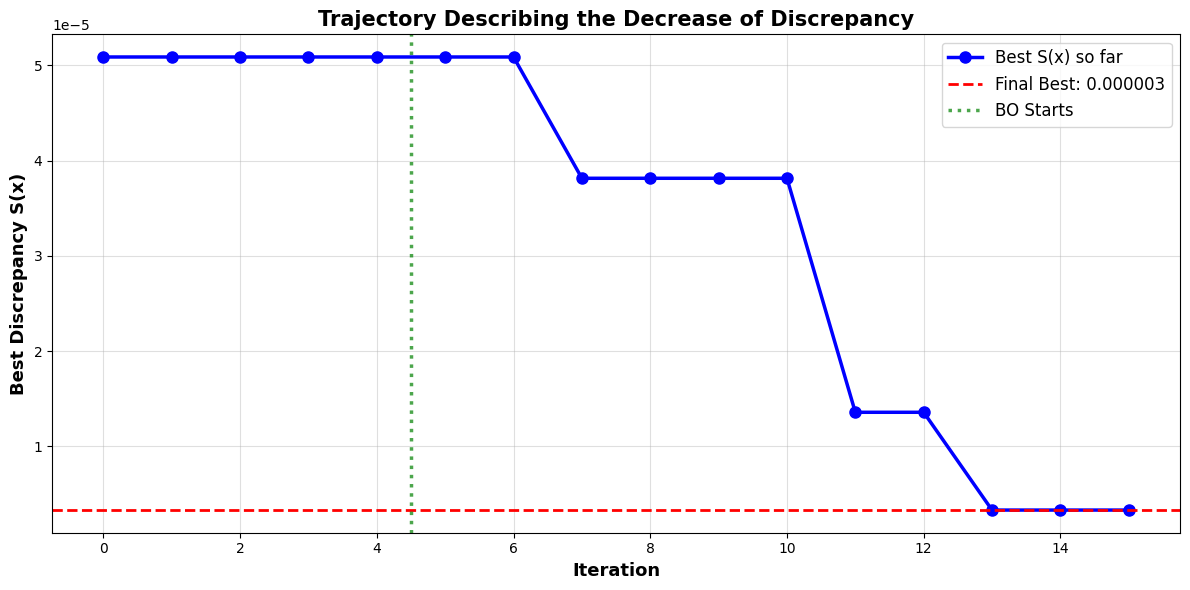


ALL EVALUATIONS

Total evaluations: 20
Initial samples:   5
BO iterations:     15
Best found at:     Evaluation #17

Statistics:
  Mean S(x):    0.000216
  Std S(x):     0.000330
  Min S(x):     0.000003 (best)
  Max S(x):     0.001187 (worst)


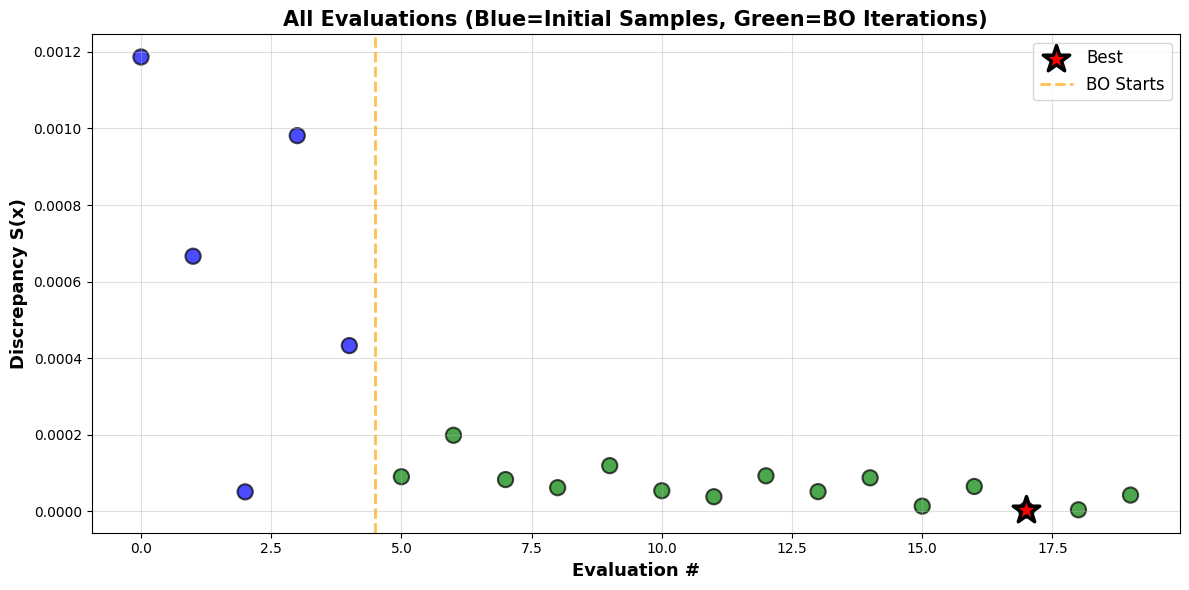


All plots saved to: output/quickstart_bo_vanilla/


In [51]:
# In your notebook - AFTER running BO

import matplotlib.pyplot as plt
import numpy as np

# ============================================================================
# 1. INSPECT THE SOLUTION
# ============================================================================

print(f"\n{'='*70}")
print("INSPECT THE SOLUTION")
print(f"{'='*70}")

# Get best OD (unnormalized)
best_od_norm = results.all_X.cpu().numpy()[results.best_idx]
best_od_real = unnormalize(
    torch.tensor(best_od_norm).unsqueeze(0), bounds
).squeeze().cpu().numpy()

print(f"\nBest Solution Found at Iteration: {results.best_idx}")
print(f"Best S(x): {results.best_S:.6f}")
print(f"Best NRMSE: {np.sqrt(results.best_S):.4f}")

print(f"\n{'OD Pair':<15} {'Ground Truth':<15} {'Best Found':<15} {'Difference':<15} {'Rel Error %':<15}")
print("-" * 75)
for i in range(len(gt_od_vals)):
    diff = best_od_real[i] - gt_od_vals[i]
    rel_err = (diff / gt_od_vals[i]) * 100
    print(f"{i:<15} {gt_od_vals[i]:<15.1f} {best_od_real[i]:<15.1f} {diff:<15.1f} {rel_err:<15.2f}")

# Plot comparison
fig, ax = plt.subplots(figsize=(10, 6))
x_pos = np.arange(len(gt_od_vals))
width = 0.35

ax.bar(x_pos - width/2, gt_od_vals, width, label='Ground Truth', 
       color='green', alpha=0.7, edgecolor='black', linewidth=1.5)
ax.bar(x_pos + width/2, best_od_real, width, label='Best Found', 
       color='orange', alpha=0.7, edgecolor='black', linewidth=1.5)

ax.set_xlabel('OD Pair Index', fontsize=13, fontweight='bold')
ax.set_ylabel('Demand (vehicles/h)', fontsize=13, fontweight='bold')
ax.set_title('Inspect the Solution: Best OD vs Ground Truth', 
             fontsize=15, fontweight='bold')
ax.set_xticks(x_pos)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(f"{config['simulation_run_path']}/solution_inspection.png", dpi=300, bbox_inches='tight')
plt.show()


# ============================================================================
# 2. TRAJECTORY DESCRIBING THE DECREASE OF DISCREPANCY
# ============================================================================

print(f"\n{'='*70}")
print("TRAJECTORY OF DISCREPANCY DECREASE")
print(f"{'='*70}")

print(f"\nInitial best S:       {results.convergence_curve[0]:.6f}")
print(f"Final best S:         {results.best_S:.6f}")
print(f"Absolute improvement: {results.convergence_curve[0] - results.best_S:.6f}")
print(f"Relative improvement: {(results.convergence_curve[0] - results.best_S)/results.convergence_curve[0]*100:.2f}%")

print(f"\nIteration-by-iteration progress:")
print(f"{'Iteration':<12} {'Best S(x)':<15} {'Best NRMSE':<15} {'Status':<20}")
print("-" * 62)
for i, s_val in enumerate(results.convergence_curve):
    nrmse = np.sqrt(s_val)
    status = "★ NEW BEST" if (i > 0 and s_val < results.convergence_curve[i-1]) else ""
    print(f"{i:<12} {s_val:<15.6f} {nrmse:<15.4f} {status:<20}")

# Plot trajectory
fig, ax = plt.subplots(figsize=(12, 6))
iterations = np.arange(len(results.convergence_curve))

ax.plot(iterations, results.convergence_curve, 'b-o', 
        linewidth=2.5, markersize=8, label='Best S(x) so far')
ax.axhline(results.best_S, color='red', linestyle='--', 
           linewidth=2, label=f'Final Best: {results.best_S:.6f}')
ax.axvline(results.iteration_start - 0.5, color='green', 
           linestyle=':', linewidth=2.5, alpha=0.7, label='BO Starts')

ax.set_xlabel('Iteration', fontsize=13, fontweight='bold')
ax.set_ylabel('Best Discrepancy S(x)', fontsize=13, fontweight='bold')
ax.set_title('Trajectory Describing the Decrease of Discrepancy', 
             fontsize=15, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.4)
plt.tight_layout()
plt.savefig(f"{config['simulation_run_path']}/trajectory_discrepancy.png", dpi=300, bbox_inches='tight')
plt.show()


# ============================================================================
# 3. ALL EVALUATIONS (Bonus)
# ============================================================================

print(f"\n{'='*70}")
print("ALL EVALUATIONS")
print(f"{'='*70}")

all_S = results.all_S.cpu().numpy()
print(f"\nTotal evaluations: {len(all_S)}")
print(f"Initial samples:   {results.iteration_start}")
print(f"BO iterations:     {len(results.acq_values)}")
print(f"Best found at:     Evaluation #{results.best_idx}")

print(f"\nStatistics:")
print(f"  Mean S(x):    {np.mean(all_S):.6f}")
print(f"  Std S(x):     {np.std(all_S):.6f}")
print(f"  Min S(x):     {np.min(all_S):.6f} (best)")
print(f"  Max S(x):     {np.max(all_S):.6f} (worst)")

fig, ax = plt.subplots(figsize=(12, 6))
colors = ['blue'] * results.iteration_start + ['green'] * len(results.acq_values)

ax.scatter(range(len(all_S)), all_S, c=colors, s=120, alpha=0.7, 
           edgecolors='black', linewidths=1.5)
ax.scatter(results.best_idx, results.best_S, c='red', s=400, 
           marker='*', edgecolors='black', linewidths=2.5, 
           label='Best', zorder=10)
ax.axvline(results.iteration_start - 0.5, color='orange', 
           linestyle='--', linewidth=2, alpha=0.7, label='BO Starts')

ax.set_xlabel('Evaluation #', fontsize=13, fontweight='bold')
ax.set_ylabel('Discrepancy S(x)', fontsize=13, fontweight='bold')
ax.set_title('All Evaluations (Blue=Initial Samples, Green=BO Iterations)', 
             fontsize=15, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.4)
plt.tight_layout()
plt.savefig(f"{config['simulation_run_path']}/all_evaluations.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\nAll plots saved to: {config['simulation_run_path']}/")


MEAN + STD UNDER MULTIPLE RESTARTS

Number of restarts: 3

Results per restart:
  Restart 1: S = 0.000000 | NRMSE = 0.0004
  Restart 2: S = 0.000000 | NRMSE = 0.0005
  Restart 3: S = 0.000002 | NRMSE = 0.0013

Aggregate statistics:
  Mean best S:   0.000001 ± 0.000001
  Min best S:    0.000000 (best restart)
  Max best S:    0.000002 (worst restart)
  Mean NRMSE:    0.0009
  Best NRMSE:    0.0004


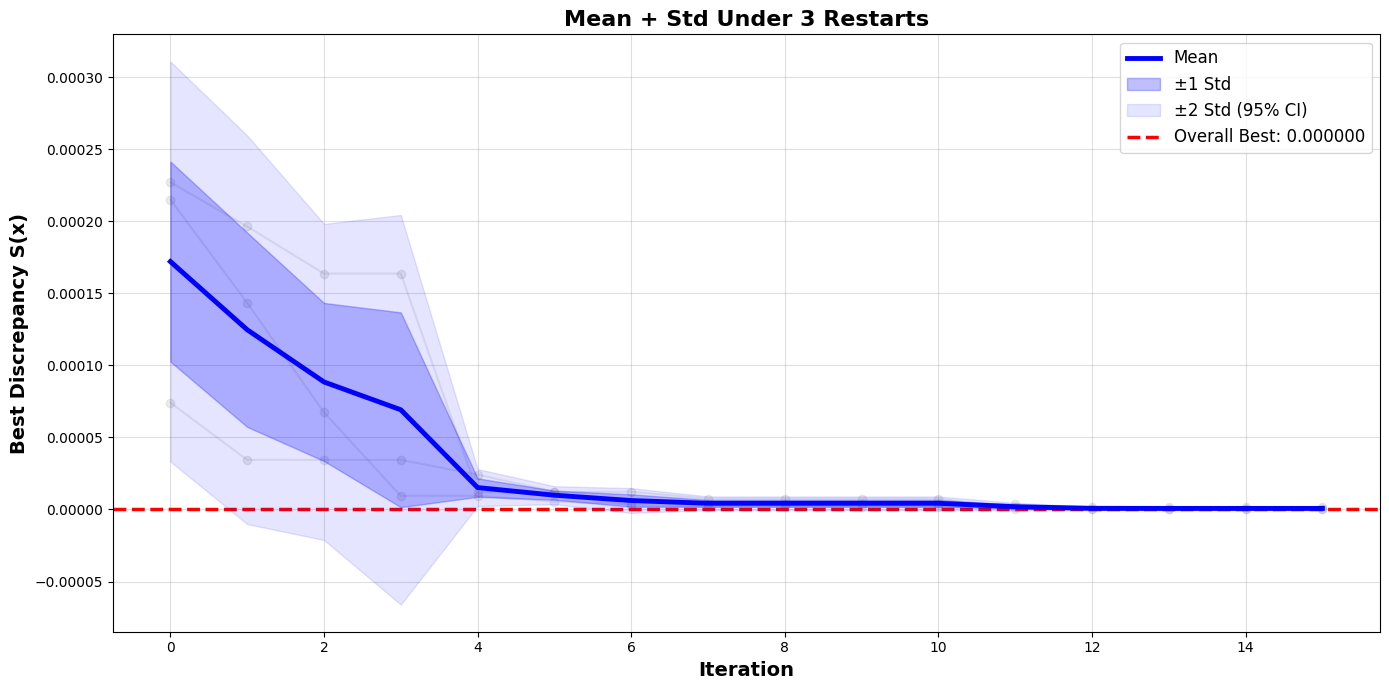


Plot saved to: output/quickstart_bo_vanilla/mean_std_multiple_restarts.png


In [52]:
# AFTER running run_multiple_bo_restarts()
#plot and results for multiple restarts

import matplotlib.pyplot as plt
import numpy as np

print(f"\n{'='*70}")
print("MEAN + STD UNDER MULTIPLE RESTARTS")
print(f"{'='*70}")

n_restarts = len(aggregated_results['best_S_all'])
best_S_all = aggregated_results['best_S_all']

print(f"\nNumber of restarts: {n_restarts}")
print(f"\nResults per restart:")
for i, s in enumerate(best_S_all):
    nrmse = np.sqrt(s)
    print(f"  Restart {i+1}: S = {s:.6f} | NRMSE = {nrmse:.4f}")

print(f"\nAggregate statistics:")
print(f"  Mean best S:   {np.mean(best_S_all):.6f} ± {np.std(best_S_all):.6f}")
print(f"  Min best S:    {np.min(best_S_all):.6f} (best restart)")
print(f"  Max best S:    {np.max(best_S_all):.6f} (worst restart)")
print(f"  Mean NRMSE:    {np.sqrt(np.mean(best_S_all)):.4f}")
print(f"  Best NRMSE:    {np.sqrt(np.min(best_S_all)):.4f}")

# Plot mean + std
fig, ax = plt.subplots(figsize=(14, 7))

mean_curve = aggregated_results['mean_curve']
std_curve = aggregated_results['std_curve']
iterations = np.arange(len(mean_curve))

# Individual restarts (faint)
for i, curve in enumerate(aggregated_results['convergence_curves']):
    valid_idx = ~np.isnan(curve)
    ax.plot(np.where(valid_idx)[0], curve[valid_idx], 
            'o-', alpha=0.15, linewidth=1.5, color='gray')

# Mean with confidence bands
ax.plot(iterations, mean_curve, 'b-', linewidth=3.5, 
        label='Mean', zorder=10)
ax.fill_between(iterations, 
                 mean_curve - std_curve, 
                 mean_curve + std_curve, 
                 color='blue', alpha=0.25, label='±1 Std', zorder=5)
ax.fill_between(iterations, 
                 mean_curve - 2*std_curve, 
                 mean_curve + 2*std_curve, 
                 color='blue', alpha=0.1, label='±2 Std (95% CI)', zorder=4)

# Overall best
overall_best = aggregated_results['overall_best_result'].best_S
ax.axhline(overall_best, color='red', linestyle='--', 
           linewidth=2.5, label=f'Overall Best: {overall_best:.6f}')

ax.set_xlabel('Iteration', fontsize=14, fontweight='bold')
ax.set_ylabel('Best Discrepancy S(x)', fontsize=14, fontweight='bold')
ax.set_title(f'Mean + Std Under {n_restarts} Restarts', 
             fontsize=16, fontweight='bold')
ax.legend(fontsize=12, loc='upper right')
ax.grid(True, alpha=0.4)
plt.tight_layout()
plt.savefig(f"{config['simulation_run_path']}/mean_std_multiple_restarts.png", 
            dpi=300, bbox_inches='tight')
plt.show()

print(f"\nPlot saved to: {config['simulation_run_path']}/mean_std_multiple_restarts.png")